In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef
from sklearn.utils import resample
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
import shap
import pickle

In [12]:
df = pd.read_csv('Bases_Test_Agua/COVID_2023_ENE_LIMPIA_INDICES_PNUD_CONRES.csv')

In [3]:
def drop_variables(df, lista_variables):
    df =  df.drop(columns = lista_variables)
    return df

Visualización de columnas presentes en la BD

In [4]:
print(df.columns)

Index(['SEXO', 'TIPO_PACIENTE', 'FECHA_SINTOMAS', 'INTUBADO', 'NEUMONIA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'UCI', '0_9', '10_19', '20_29', '30_39', '40_49', '50_59',
       '60_69', '70_MAS', 'CLAVE_RES', 'IDH_VALOR', 'SS_VALOR', 'SI_VALOR',
       'IDH_BAJO', 'IDH_MEDIO', 'IDH_ALTO', 'IDH_MUY_ALTO', 'SS_BAJO',
       'SS_MEDIO', 'SS_ALTO', 'SS_MUY_ALTO', 'SI_BAJO', 'SI_MEDIO', 'SI_ALTO',
       'SI_MUY_ALTO', 'UM_IMSS', 'UM_ISSTE', 'UM_MILITAR', 'UM_PRIVADA',
       'UM_SSA', 'UM_OTRAS', 'DEFUNCION'],
      dtype='object')


In [13]:
df.shape

(3224501, 48)

In [14]:
# Revisar la distribución de la variable objetivo
print(df['DEFUNCION'].value_counts())
print(df['TIPO_PACIENTE'].value_counts())


DEFUNCION
0    3199553
1      24948
Name: count, dtype: int64
TIPO_PACIENTE
1    3133286
0      91215
Name: count, dtype: int64


Variables que no ingresan al modelo (versión con componentes)

In [5]:
# Variables que no ingresan al modelo (versión con componentes)

variables_no_utilizadas = ['FECHA_SINTOMAS', 'CLAVE_RES', 'IDH_VALOR', 'SS_VALOR', 'SI_VALOR']

In [6]:
df = drop_variables(df, variables_no_utilizadas)

Variables que no ingresan al modelo (versión sin componentes)

In [66]:
# Variables que no ingresan al modelo (versión sin componentes)

variables_no_utilizadas = ['FECHA_SINTOMAS', 'CLAVE_RES', 'IDH_VALOR', 'SS_VALOR', 'SI_VALOR']

# Coastal
variables_no_utilizadas_coastal = ['coast_comp_TSS', 'coast_comp_FC', 'coast_comp_ODs', 'coast_comp_ODm',
                            'coast_comp_ODb', 'coast_comp_FE', 'coast_comp_TF15s', 'coast_comp_TF15b']

# Groundwater 
variables_no_utilizadas_gw = ['gw_comp_Alk', 'gw_comp_Cond', 'gw_comp_Hard', 'gw_comp_TDS', 'gw_comp_Fe',
                            'gw_comp_Mn', 'gw_comp_F', 'gw_comp_FC', 'gw_comp_NO3N', 'gw_comp_As',
                            'gw_comp_Cd', 'gw_comp_Cr', 'gw_comp_Hg', 'gw_comp_Pb']

# Lentic
variables_no_utilizadas_lentic = ['len_comp_TSS', 'len_comp_FC', 'len_comp_ECOLI', 'len_comp_ODs', 
                                  'len_comp_ODm', 'len_comp_ODb', 'len_comp_BOD5', 'len_comp_COD', 
                                  'len_comp_TD48s', 'len_comp_TD48b', 'len_comp_TF15s', 'len_comp_TF15b']

# Lotic
variables_no_utilizadas_lotic = ['lot_comp_TSS', 'lot_comp_FC', 'lot_comp_ECOLI', 'lot_comp_OD',
                                'lot_comp_BOD5', 'lot_comp_COD', 'lot_comp_TD48', 'lot_comp_TF15']

In [157]:
df = drop_variables(df, variables_no_utilizadas)
df = drop_variables(df, variables_no_utilizadas_gw)

In [7]:
# Renombrar columnas necesarias

df = df.rename(columns={'SEXO': 'Woman', 'TIPO_PACIENTE': 'Outpatient', 'INTUBADO': 'Intubated', 'DIABETES': 'Diabetes',
                   'NEUMONIA': 'Pneumonia', 'EPOC': 'COPD', 'ASMA': 'Asthma', 'INMUSUPR': 'Immunosuppression',
                   'HIPERTENSION': 'Hypertension', 'OBESIDAD': 'Obesity', 'RENAL_CRONICA': 'CKD', 'CARDIOVASCULAR': 'Cardiovascular',
                   'TABAQUISMO': 'Smoking', 'OTRO_CASO': 'Contact w/another', 'UCI': 'ICU', '70_MAS': '70 or older',
                   'IDH_BAJO': 'Low H.D.I.', 'IDH_MEDIO': 'Medium H.D.I.', 'IDH_ALTO': 'High H.D.I.',
                   'IDH_MUY_ALTO': 'Very High H.D.I.', 'SS_BAJO': 'Low H.S.', 'SS_MEDIO': 'Medium H.S.',
                   'SS_ALTO': 'High H.S.', 'SS_MUY_ALTO': 'Very High H.S.', 'SI_BAJO': 'Low I.S.',
                   'SI_MEDIO': 'Medium I.S.', 'SI_ALTO': 'High I.S.', 'SI_MUY_ALTO': 'Very High I.S.',
                   'UM_IMSS': 'MU IMSS', 'UM_ISSTE': 'MU ISSSTE', 'UM_MILITAR': 'MU Military', 'UM_PRIVADA': 'MU Private',
                   'UM_SSA': 'MU SSA', 'UM_OTRAS': 'MU Others', '0_9': '0-9 y.o.', '10_19': '10-19 y.o.', '20_29': '20-29 y.o.',
                   '30_39': '30-39 y.o.', '40_49': '40-49 y.o.', '50_59': '50-59 y.o.', '60_69': '60-69 y.o.'})

In [8]:
# Coastal

df = df.rename(columns={'CA_COAST_MALA': 'Poor water quality', 'CA_COAST_REGULAR': 'Regular water quality',
                   'CA_COAST_BUENA': 'Good water quality'})

In [8]:
# Groundwater

df = df.rename(columns={'CA_SUB_MALA': 'Poor water quality', 'CA_SUB_REGULAR': 'Regular water quality',
                   'CA_SUB_BUENA': 'Good water quality'})

In [10]:
# Lentic

df = df.rename(columns={'CA_LENTICA_MALA': 'Poor water quality', 'CA_LENTICA_REGULAR': 'Regular water quality',
                   'CA_LENTICA_BUENA': 'Good water quality', 'len_comp_TSS': 'Complies TSS',
                   'len_comp_FC': 'Complies FC', 'len_comp_ECOLI': 'Complies ECOLI', 'len_comp_ODs': 'Complies ODs',
                   'len_comp_ODm': 'Complies ODm', 'len_comp_ODb': 'Complies ODb', 'len_comp_BOD5': 'Complies BOD5',
                   'len_comp_COD': 'Complies COD', 'len_comp_TD48s': 'Complies TD48s',
                   'len_comp_TD48b': 'Complies TD48b', 'len_comp_TF15s': 'Complies TF15s', 'len_comp_TF15b': 'Complies TF15b'})

In [52]:
# Lotic

df = df.rename(columns={'CA_LOTICA_MALA': 'Poor water quality', 'CA_LOTICA_REGULAR': 'Regular water quality',
                   'CA_LOTICA_BUENA': 'Good water quality', 'lot_comp_TSS': 'Complies TSS', 'lot_comp_FC': 'Complies FC',
                   'lot_comp_ECOLI': 'Complies ECOLI', 'lot_comp_OD': 'Complies OD', 'lot_comp_BOD5': 'Complies BOD5',
                   'lot_comp_COD': 'Complies COD', 'lot_comp_TD48': 'Complies TD48', 'lot_comp_TF15': 'Complies TF15'})

Visualización de variables que se usarán para los modelos

In [9]:
print(df.columns)

Index(['Woman', 'Outpatient', 'Intubated', 'Pneumonia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular',
       'Obesity', 'CKD', 'Smoking', 'Contact w/another', 'ICU', '0-9 y.o.',
       '10-19 y.o.', '20-29 y.o.', '30-39 y.o.', '40-49 y.o.', '50-59 y.o.',
       '60-69 y.o.', '70 or older', 'Low H.D.I.', 'Medium H.D.I.',
       'High H.D.I.', 'Very High H.D.I.', 'Low H.S.', 'Medium H.S.',
       'High H.S.', 'Very High H.S.', 'Low I.S.', 'Medium I.S.', 'High I.S.',
       'Very High I.S.', 'MU IMSS', 'MU ISSSTE', 'MU Military', 'MU Private',
       'MU SSA', 'MU Others', 'DEFUNCION', 'gw_comp_Alk', 'gw_comp_Cond',
       'gw_comp_Hard', 'gw_comp_TDS', 'gw_comp_Fe', 'gw_comp_Mn', 'gw_comp_F',
       'gw_comp_FC', 'gw_comp_NO3N', 'gw_comp_As', 'gw_comp_Cd', 'gw_comp_Cr',
       'gw_comp_Hg', 'gw_comp_Pb', 'Poor water quality',
       'Regular water quality', 'Good water quality'],
      dtype='object')


# **Balance de datos creando splits**   

El ratio de sobrevivientes-no sobrevivientes se ajusta con k(num_fallecidos)

In [12]:
# Función para balancear los datos
def balancear_datos(df, target_col='DEFUNCION'):
    fallecidos = df[df[target_col] == 1]
    sobrevivientes = df[df[target_col] == 0]
    num_fallecidos = len(fallecidos)
    ratio = num_fallecidos  # Balance 1:1
    divisiones = []

    while len(sobrevivientes) >= num_fallecidos:
        if len(sobrevivientes) < ratio:
            ratio = len(sobrevivientes)
        sobrevivientes_muestra = resample(sobrevivientes, replace=False, n_samples=ratio, random_state=42)
        df_balanceado = pd.concat([fallecidos, sobrevivientes_muestra])
        divisiones.append(df_balanceado)
        sobrevivientes = sobrevivientes.drop(sobrevivientes_muestra.index)

    return divisiones

In [23]:
# Ajustar s_p_w al ratio de desbalance de splits
scale_pos_weight = 1

In [41]:
# Aplicar la función al dataset
divisiones_balanceadas = balancear_datos(df)

In [34]:
for i, division in enumerate(divisiones_balanceadas):
    print(f"Split {i + 1}: Total de registros = {len(division)}, Fallecidos = {sum(division['DEFUNCION'] == 1)}, Sobrevivientes = {sum(division['DEFUNCION'] == 0)}")

Split 1: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 2: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 3: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 4: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 5: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 6: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 7: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 8: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 9: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 10: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 11: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
Split 12: Total de registros = 347688, Fallecidos = 173844, Sobrevivientes = 173844
S

In [42]:
# Función para concatenar splits (análisis estadístico)
def concatenar_splits(divisiones_balanceadas):
    
    fallecidos_unicos = divisiones_balanceadas[0][divisiones_balanceadas[0]['DEFUNCION'] == 1]
    sobrevivientes_concatenados = pd.concat([division[division['DEFUNCION'] == 0] for division in divisiones_balanceadas])

    df_final = pd.concat([fallecidos_unicos, sobrevivientes_concatenados])

    return df_final

df_concatenado = concatenar_splits(divisiones_balanceadas)

print(f"Total registros concatenados: {len(df_concatenado)}")
print(f"Fallecidos en conjunto concatenado: {sum(df_concatenado['DEFUNCION'] == 1)}")
print(f"Sobrevivientes en conjunto concatenado: {sum(df_concatenado['DEFUNCION'] == 0)}")

Total registros concatenados: 1052742
Fallecidos en conjunto concatenado: 30963
Sobrevivientes en conjunto concatenado: 1021779


In [43]:
condiciones = {
    'MU IMSS': 1,
    'MU ISSSTE': 1,
    'MU Military': 1,
    'MU Private': 1,
    'MU SSA': 1,
    'MU Others': 1
    #'Outpatient': 0,
    #'Intubated': 1,
    #'Pneumonia': 1,
    #'Hypertension': 1,
    #'Obesity': 1,
    #'Diabetes': 1,
    #'Smoking': 1,
    #'70 or older': 1,
    #'20-29 y.o.': 1,
}

porcentajes = {}

for column, valor in condiciones.items():
    filtered_cases = df_concatenado[df_concatenado[column] == valor]
    count = len(filtered_cases)
    percentage = (count / len(df_concatenado)) * 100 if len(df) > 0 else 0
    porcentajes[column] = {'count': count, 'percentage': percentage}

for key, valor in porcentajes.items():
    print(f"{key}: {valor['count']} casos, {valor['percentage']:.2f}%")

MU IMSS: 624435 casos, 59.32%
MU ISSSTE: 36640 casos, 3.48%
MU Military: 8031 casos, 0.76%
MU Private: 71945 casos, 6.83%
MU SSA: 280491 casos, 26.64%
MU Others: 31200 casos, 2.96%


In [ ]:
# Definir los rangos de edad
rangos_edad = ['0-9 y.o.', '10-19 y.o.', '20-29 y.o.', '30-39 y.o.', '40-49 y.o.', '50-59 y.o.', '60-69 y.o.', '70 or older']

# Condiciones para los demás síntomas
condiciones = {
    'Outpatient': 0,
    'Pneumonia': 1,
    'Intubated': 1,
    'Diabetes': 1,
    'Hypertension': 1,
    'Obesity': 1,
    'Contact with another case': 1
}

resultados = pd.DataFrame(index=rangos_edad, columns=[f"{col}_cant" for col in condiciones.keys()] + [f"{col}_porcentaje" for col in condiciones.keys()])

# Iterar sobre cada rango de edad
for rango in rangos_edad:
    # Filtrar los registros del rango de edad actual
    filtered_rango = df_concatenado[df_concatenado[rango] == 1]

    # Si no hay casos en este rango, continuamos al siguiente
    if len(filtered_rango) == 0:
        continue

    # Calcular el total de casos en el rango
    total_casos = len(filtered_rango)

    # Evaluar cada condición
    for columna, valor in condiciones.items():
        filtered_cases = filtered_rango[filtered_rango[columna] == valor]
        count = len(filtered_cases)
        percentage = (count / total_casos) * 100 if total_casos > 0 else 0
        
        # Almacenar los resultados en el DataFrame
        resultados.at[rango, f"{columna}_cant"] = count
        resultados.at[rango, f"{columna}_porcentaje"] = round(percentage,3)

# Rellenar valores NaN con 0 para facilitar la lectura
resultados.fillna(0, inplace=True)

# Mostrar el DataFrame de resultados
resultados

Análisis sobre UMs

In [19]:
# Definir las UMs
unidades_medicas = ['MU IMSS', 'MU ISSTE', 'MU Military', 'MU Private', 'MU SSA', 'MU Others']

# Condiciones
condiciones_ums = {
    'Outpatient': 0,
    'Pneumonia': 1,
    'Immunosuppression': 1,
    'Intubated': 1,
    'Diabetes': 1,
    'Hypertension': 1,
    'CKD': 1,
    'Obesity': 1,
    'Contact w/another': 1
}

resultados_ums = pd.DataFrame(index=unidades_medicas, columns=[f"{col}_cant" for col in condiciones_ums.keys()] + [f"{col}_porcentaje" for col in condiciones_ums.keys()])

# Iterar sobre cada rango de edad
for unidad in unidades_medicas:
    # Filtrar los registros del rango de edad actual
    filtered_unidad = df_concatenado[df_concatenado[unidad] == 1]

    # Si no hay casos en este rango, continuamos al siguiente
    if len(filtered_unidad) == 0:
        continue

    # Calcular el total de casos en el rango
    total_casos_ums = len(filtered_unidad)

    # Evaluar cada condición
    for columna, valor in condiciones_ums.items():
        filtered_unidad = filtered_unidad[filtered_unidad[columna] == valor]
        count = len(filtered_unidad)
        percentage = (count / total_casos_ums) * 100 if total_casos_ums > 0 else 0
        
        # Almacenar los resultados en el DataFrame
        resultados_ums.at[unidad, f"{columna}_cant"] = count
        resultados_ums.at[unidad, f"{columna}_porcentaje"] = round(percentage,3)

# Rellenar valores NaN con 0 para facilitar la lectura
resultados_ums.fillna(0, inplace=True)

# Mostrar el DataFrame de resultados
resultados_ums

Outpatient_cant Pneumonia_cant Immunosuppression_cant  \
MU IMSS               35566          20608                    775   
MU ISSTE               4569           3259                     97   
MU Military            1770           1008                     18   
MU Private             2192           1718                     57   
MU SSA                19742          15259                    383   
MU Others              2739           2135                    114   

            Intubated_cant Diabetes_cant Hypertension_cant CKD_cant  \
MU IMSS                113            76                52        9   
MU ISSTE                25             8                 5        1   
MU Military              8             5                 4        0   
MU Private              13             3                 2        0   
MU SSA                  79            32                17        4   
MU Others               26            18                13        0   

            Obesity_cant Contact w/another_cant Outpatient_porcentaje  \
MU IMSS                1                      0                 5.696   
MU ISSTE               0                      0                 12.47   
MU Military            0                      0                 22.04   
MU Private             0                      0                 3.047   
MU SSA                 2                      1                 7.038   
MU Others              0                      0                 8.779   

            Pneumonia_porcentaje Immunosuppression_porcentaje  \
MU IMSS                      3.3                        0.124   
MU ISSTE                   8.895                        0.265   
MU Military               12.551                        0.224   
MU Private                 2.388                        0.079   
MU SSA                      5.44                        0.137   
MU Others                  6.843                        0.365   

            Intubated_porcentaje Diabetes_porcentaje Hypertension_porcentaje  \
MU IMSS                    0.018               0.012                   0.008   
MU ISSTE                   0.068               0.022                   0.014   
MU Military                  0.1               0.062                    0.05   
MU Private                 0.018               0.004                   0.003   
MU SSA                     0.028               0.011                   0.006   
MU Others                  0.083               0.058                   0.042   

            CKD_porcentaje Obesity_porcentaje Contact w/another_porcentaje  
MU IMSS              0.001                0.0                          0.0  
MU ISSTE             0.003                0.0                          0.0  
MU Military            0.0                0.0                          0.0  
MU Private             0.0                0.0                          0.0  
MU SSA               0.001              0.001                          0.0  
MU Others              0.0                0.0                          0.0

In [ ]:
# Filtrar solo las columnas que terminan en "_porcentaje"
porcentaje_columns = [col for col in resultados.columns if col.endswith('_porcentaje')]

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resultados[porcentaje_columns].astype(float), annot=True, cmap='YlGnBu', fmt='.3f', cbar_kws={'label': 'Percentage'}, 
            xticklabels=porcentaje_columns, yticklabels=resultados.index)

# Título y etiquetas
plt.title('Heatmap of Condition Percentages by Age Range')
plt.xlabel('Conditions')
plt.ylabel('Age Range')

plt.tight_layout()  # Para evitar que se solapen los elementos
plt.show()

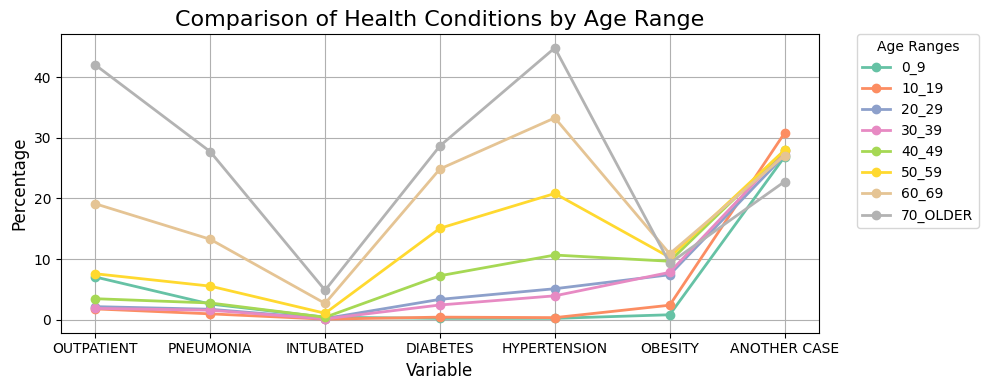

In [204]:
# Filtrar las columnas de porcentaje
porcentaje_columns = [col for col in resultados.columns if col.endswith('_porcentaje')]

conditions = []

for col in porcentaje_columns:
    if col == 'ANOTHER_CASE_porcentaje':
        conditions.append('ANOTHER CASE')
    else:
        conditions.append(col.split('_')[0])  

# Crear una figura
plt.figure(figsize=(10, 4))

# Definir colores para los rangos de edad
colores = sns.color_palette("Set2", n_colors=len(resultados.index))

# Iterar sobre cada rango de edad y graficar
for i, age_range in enumerate(resultados.index):
    # Obtener los valores de porcentaje para el rango de edad
    values = resultados.loc[age_range, porcentaje_columns].values

    # Graficar la línea para el rango de edad actual
    plt.plot(conditions, values, label=age_range, color=colores[i], marker='o', linewidth=2)

# Personalizar el gráfico
plt.title("Comparison of Health Conditions by Age Range", size=16)
plt.xlabel("Variable", size=12)
plt.ylabel("Percentage", size=12)

# Mostrar la leyenda
plt.legend(title="Age Ranges", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Mejorar la visualización con un estilo de grid
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

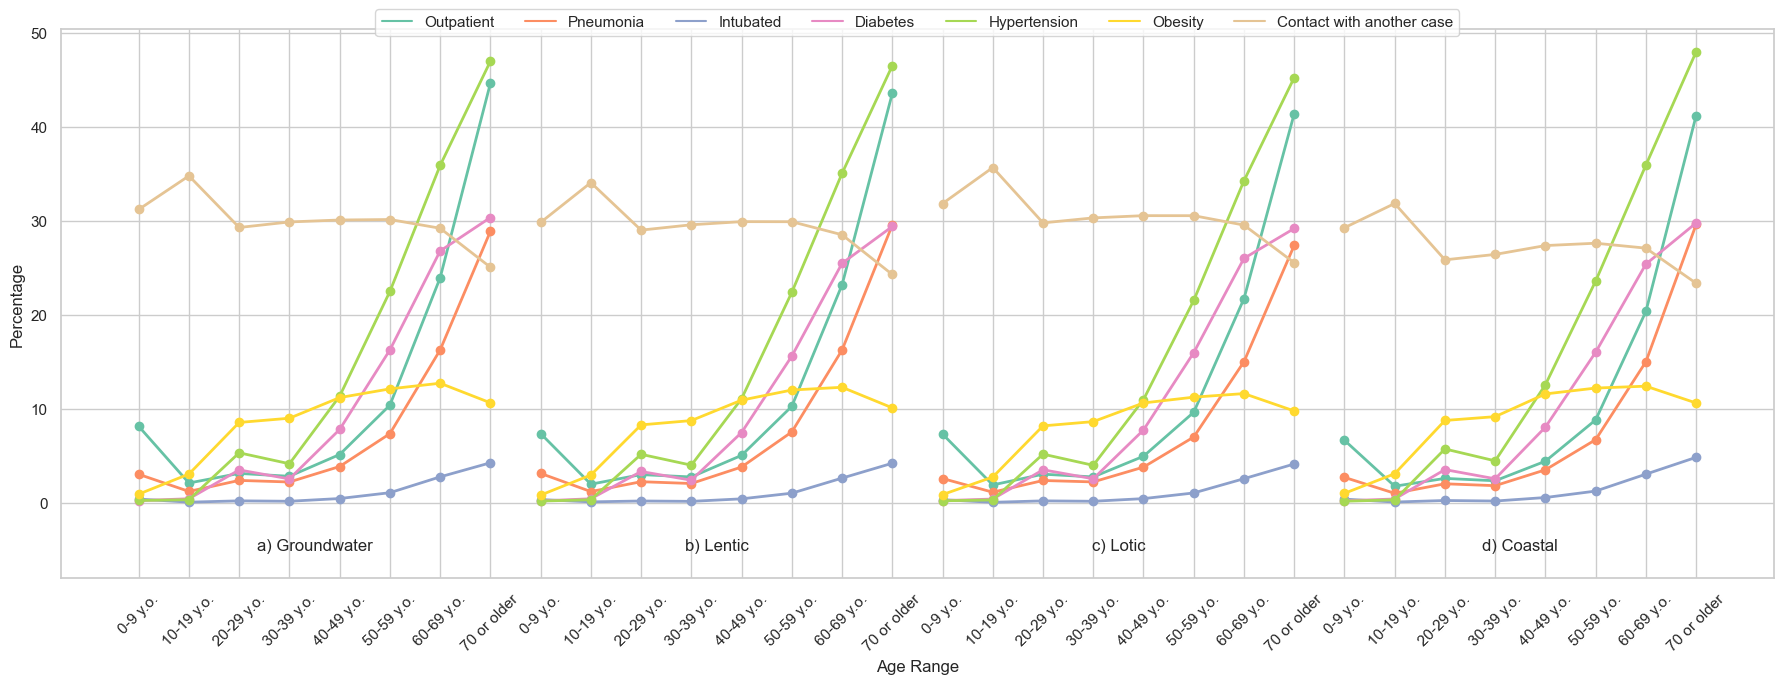

In [203]:
resultados_dfs = [resultados_gw, resultados_lentic, resultados_lotic, resultados_coastal]
incisos = ['(a)', '(b)', '(c)', '(d)']
dataset_labels = ['a) Groundwater', 'b) Lentic', 'c) Lotic', 'd) Coastal']

colores = sns.color_palette("Set2", n_colors=len(condiciones))
plt.figure(figsize=(18, 7))

offsets = [0, 1, 2, 3]  # Desplazamientos en el eje X para los 4 datasets
eje_x_repetido = rangos_edad * len(resultados_dfs)  # Repetir los rangos 4 veces

added_conditions = set()


for idx, resultados in enumerate(resultados_dfs):
    # Desplazamiento
    offset = idx * len(rangos_edad)
    

    for i, condition in enumerate(condiciones.keys()):

        values = resultados[f"{condition}_porcentaje"].values
        
        line, = plt.plot(
            [x + offset for x in range(len(rangos_edad))], 
            values, 
            color=colores[i], 
            marker='o', 
            linewidth=2
        )

        # Añadir la condición a la leyenda una sola vez
        if condition not in added_conditions:
            plt.plot([], [], label=condition, color=colores[i])
            added_conditions.add(condition)

    middle_x_pos = (offset + offset + len(rangos_edad) - 1) / 2  # Posición de las líneas
    plt.text(
        middle_x_pos, 
        -5,
        dataset_labels[idx],
        ha='center', 
        fontsize=12, 
        #fontweight='bold'
    )

plt.ylim(bottom=-8)

#plt.title("Comparison of Health Conditions by Age Range (Across Datasets)", size=16)
plt.xlabel("Age Range", size=12)
plt.ylabel("Percentage", size=12)

plt.xticks(range(len(eje_x_repetido)), eje_x_repetido, rotation=45)

plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=7)
plt.tight_layout()
plt.show()

# Búsqueda de hiperparámetros

**Definición de los hiperparámetros a ulitizar y el espacio de búsqueda**

In [ ]:
param_grid_1 = {'max_depth': range(3, 10, 1),
                'min_child_weight': range(3, 6, 1)}
param_grid_2 = {'gamma': [i / 10.0 for i in range(0, 6)]}
param_grid_3 = {'subsample': [i / 10.0 for i in range(1, 11)],
                'colsample_bytree': [i / 10.0 for i in range(2, 11)]}
param_grid_4 = {'reg_lambda': [i / 10.0 for i in range(3, 11)],
                'n_estimators': range(50, 151, 50)}

In [ ]:
# Diccionario para almacenar los mejores parámetros
best_params_divisiones_balanceadas = {}

# Lista para almacenar los subconjuntos de entrenamiento y prueba de cada split hecho por Minority Class Replication
train_test_splits = []

**Grid search con stratified cross validation**

Nota: Este procedimineto es muy demandante, el tiempo estimado de búsqueda en el espacio presentado de ejemplo, toma aproximadamente 180 minutos usando 16 hilos.

La cantidad de hilos se regula en el parámetro n_jobs, siendo que -1 representa usar todos los disponibles.

Una menor cantidad de hilos hace la tarea menos pesada, por lo que se puede limitar si este proceso crashea al ejecuta, pero implica un mayor tiempo de búsqueda.

In [ ]:
for idx, division in enumerate(divisiones_balanceadas):
    print(f"Procesando la División {idx + 1}")

    # Separar en características y variable objetivo
    X = division.drop('DEFUNCION', axis=1)
    y = division['DEFUNCION']

    # Partición en train/test antes de la búsqueda de hiperparámetros
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=196, stratify=y)

    # Verificación de tamaños
    print(f"Tamaño de X_train: {X_train.shape}, X_test: {X_test.shape}")

    train_test_splits.append({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    print(f"Número actual de splits en train_test_splits: {len(train_test_splits)}")

    # Definir validación cruzada solo en el conjunto de entrenamiento
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=196)

     # Inicializar el modelo para la búsqueda de hiperparámetros
    model = xgb.XGBClassifier(objective='binary:logistic',
                              scale_pos_weight=scale_pos_weight,
                              tree_method='hist', device='cuda',
                              random_state=196, eval_metric='auc')

    # Diccionario para guardar los mejores parámetros del split actual
    best_params = {}

    # Realizar Grid Search por cada segmento (en el conjunto de entrenamiento)
    for i, param_grid in enumerate([param_grid_1, param_grid_2, param_grid_3, param_grid_4], 1):
        print(f"Optimización del Segmento {i} en la División {idx + 1}: {list(param_grid.keys())}")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)  # Solo entrenar en los datos de entrenamiento

        # Mostrar los mejores parámetros encontrados para el segmento
        print(f"Mejores parámetros del Segmento {i}: {grid_search.best_params_}\n")
        model.set_params(**grid_search.best_params_)  # Actualizar modelo con mejores parámetros
        best_params.update(grid_search.best_params_)

    # Guardar los mejores parámetros para el split actual
    best_params_divisiones_balanceadas[f'Division_{idx + 1}'] = best_params

In [61]:
# Debug
print(f"Número de divisiones en divisiones_balanceadas: {len(divisiones_balanceadas)}")

print(f"Número de divisiones en train_test: {len(train_test_splits)}")

Número de divisiones en divisiones_balanceadas: 31
Número de divisiones en train_test: 31


# Test y evaluación


Evaluando el rendimiento para la División 1
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



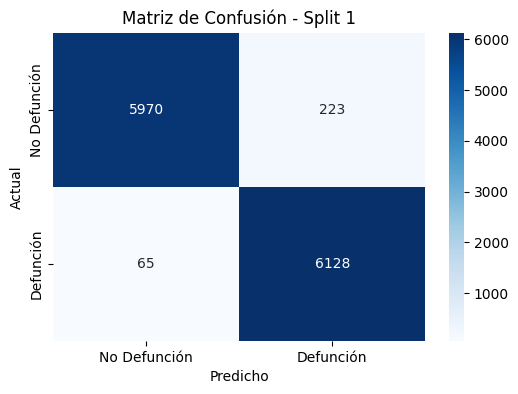

Scores para Clase 0 (Test):
  Precisión: 0.9892, Recall: 0.9640, F1-Score: 0.9764
Scores para Clase 1 (Test):
  Precisión: 0.9649, Recall: 0.9895, F1-Score: 0.9770


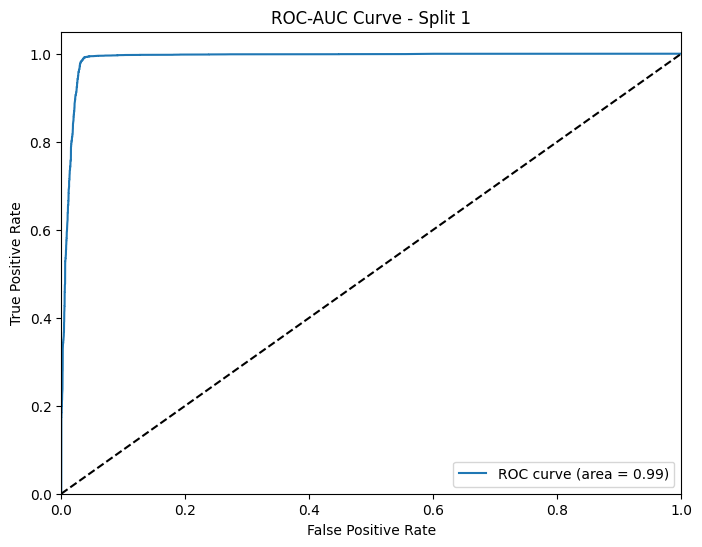


Evaluando el rendimiento para la División 2
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



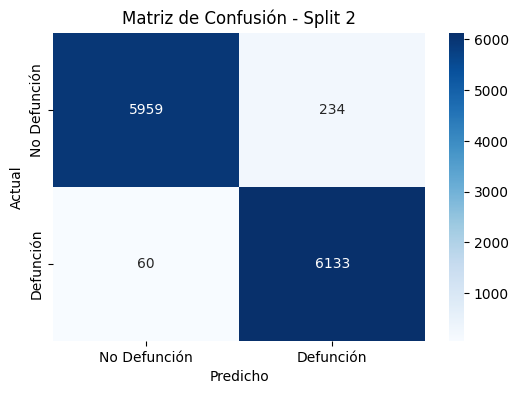

Scores para Clase 0 (Test):
  Precisión: 0.9900, Recall: 0.9622, F1-Score: 0.9759
Scores para Clase 1 (Test):
  Precisión: 0.9632, Recall: 0.9903, F1-Score: 0.9766


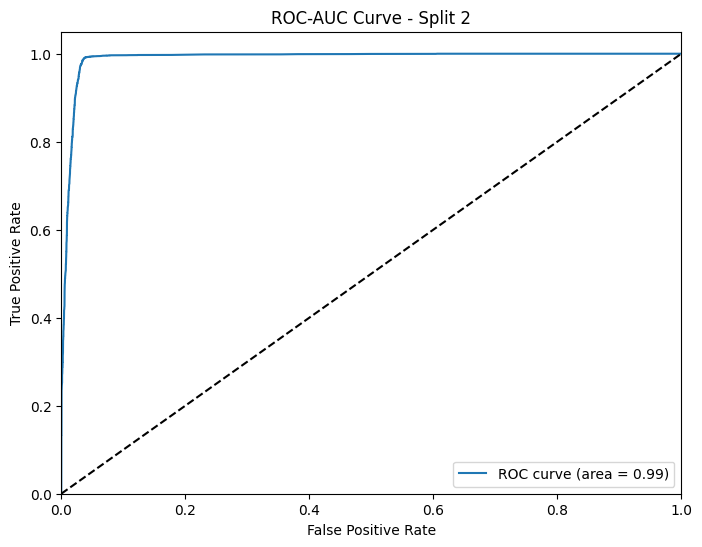


Evaluando el rendimiento para la División 3
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



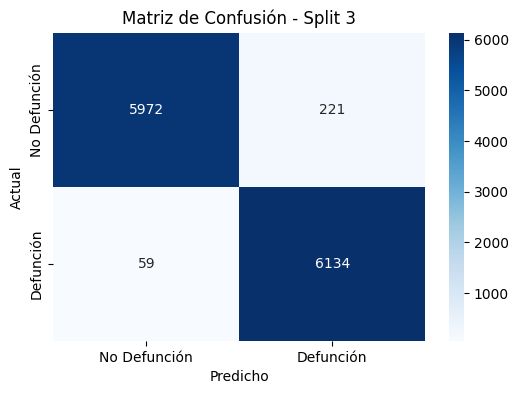

Scores para Clase 0 (Test):
  Precisión: 0.9902, Recall: 0.9643, F1-Score: 0.9771
Scores para Clase 1 (Test):
  Precisión: 0.9652, Recall: 0.9905, F1-Score: 0.9777


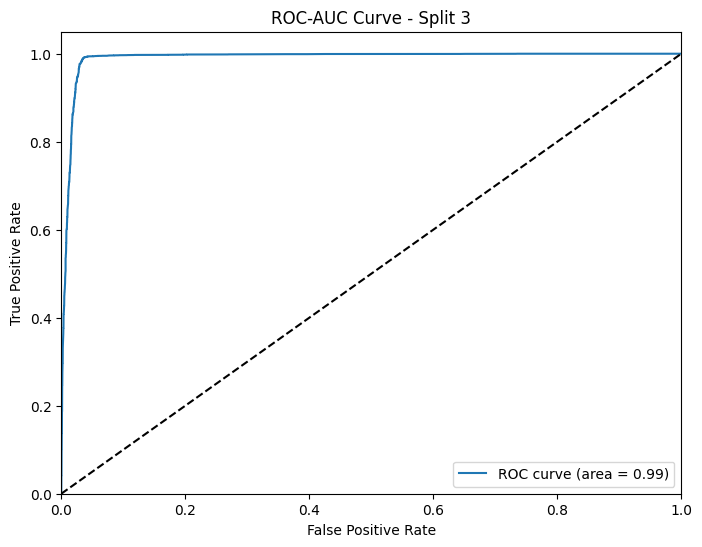


Evaluando el rendimiento para la División 4
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



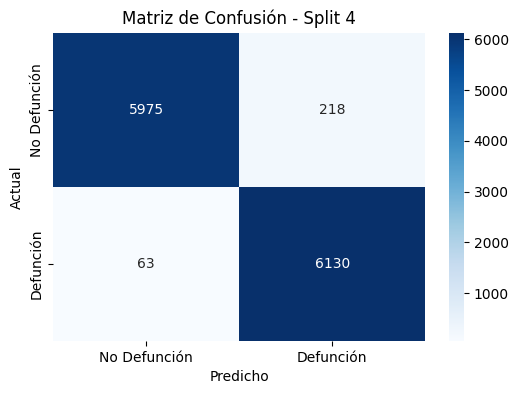

Scores para Clase 0 (Test):
  Precisión: 0.9896, Recall: 0.9648, F1-Score: 0.9770
Scores para Clase 1 (Test):
  Precisión: 0.9657, Recall: 0.9898, F1-Score: 0.9776


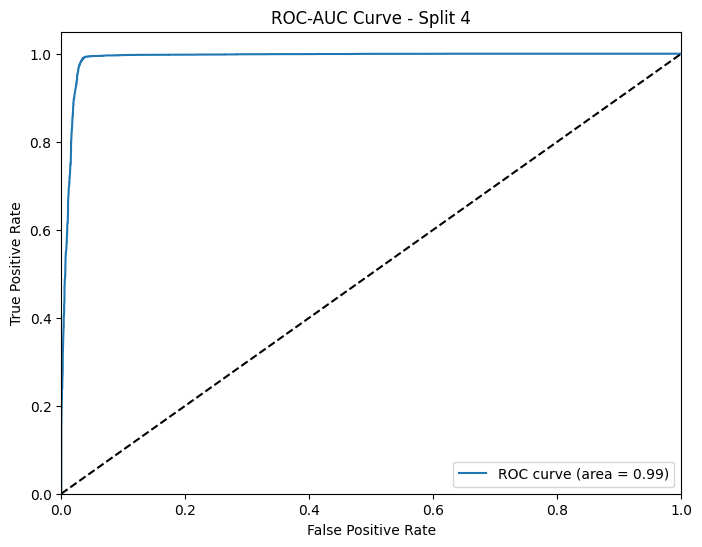


Evaluando el rendimiento para la División 5
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



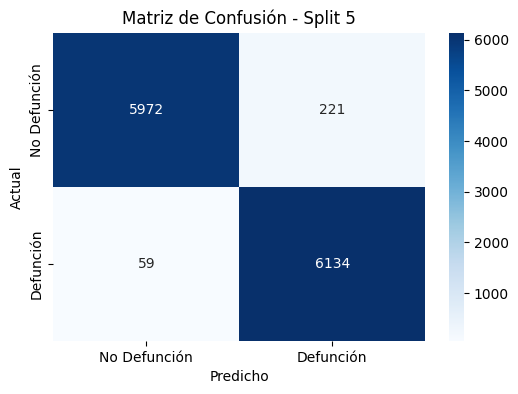

Scores para Clase 0 (Test):
  Precisión: 0.9902, Recall: 0.9643, F1-Score: 0.9771
Scores para Clase 1 (Test):
  Precisión: 0.9652, Recall: 0.9905, F1-Score: 0.9777


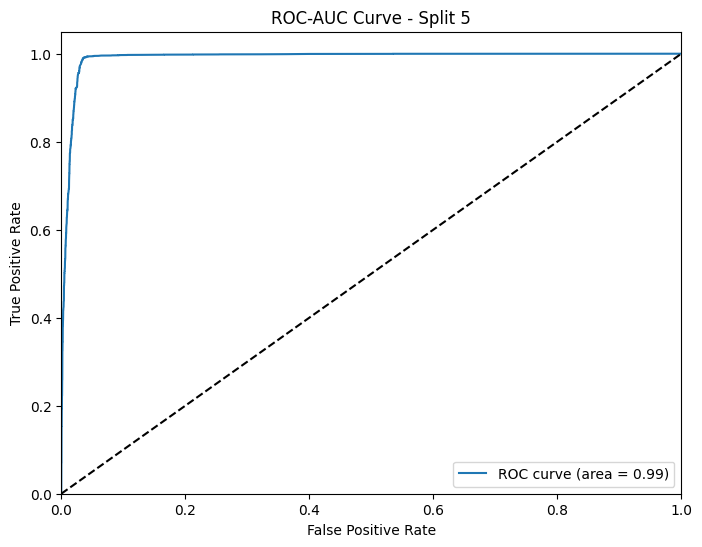


Evaluando el rendimiento para la División 6
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



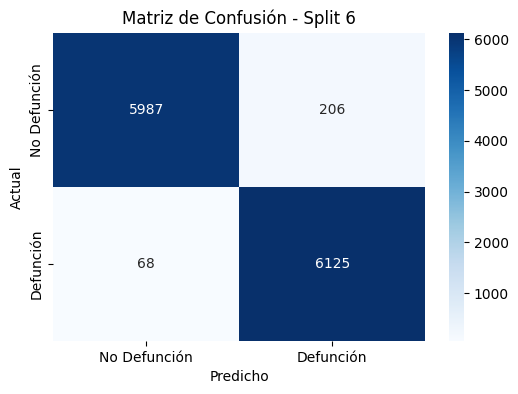

Scores para Clase 0 (Test):
  Precisión: 0.9888, Recall: 0.9667, F1-Score: 0.9776
Scores para Clase 1 (Test):
  Precisión: 0.9675, Recall: 0.9890, F1-Score: 0.9781


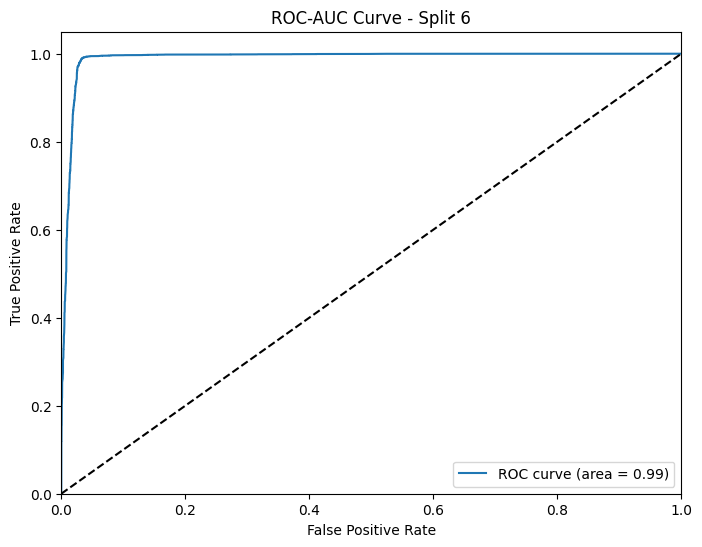


Evaluando el rendimiento para la División 7
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



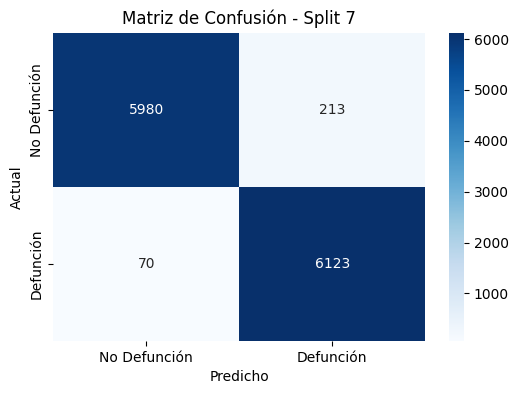

Scores para Clase 0 (Test):
  Precisión: 0.9884, Recall: 0.9656, F1-Score: 0.9769
Scores para Clase 1 (Test):
  Precisión: 0.9664, Recall: 0.9887, F1-Score: 0.9774


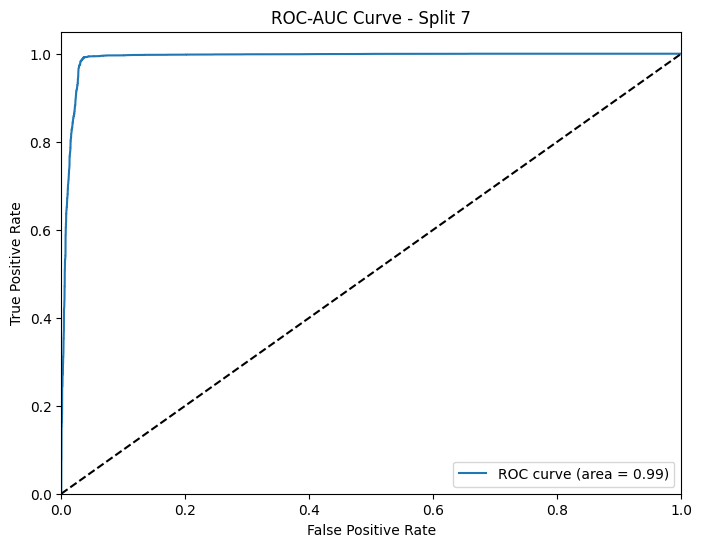


Evaluando el rendimiento para la División 8
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



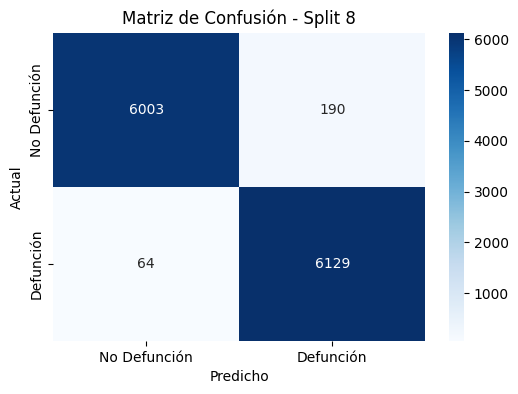

Scores para Clase 0 (Test):
  Precisión: 0.9895, Recall: 0.9693, F1-Score: 0.9793
Scores para Clase 1 (Test):
  Precisión: 0.9699, Recall: 0.9897, F1-Score: 0.9797


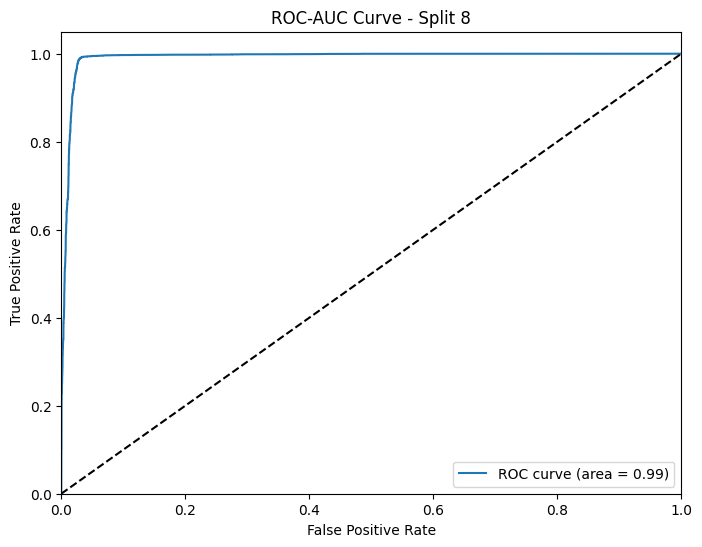


Evaluando el rendimiento para la División 9
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.97      6193
   Defunción       0.96      0.99      0.97      6193

    accuracy                           0.97     12386
   macro avg       0.97      0.97      0.97     12386
weighted avg       0.97      0.97      0.97     12386



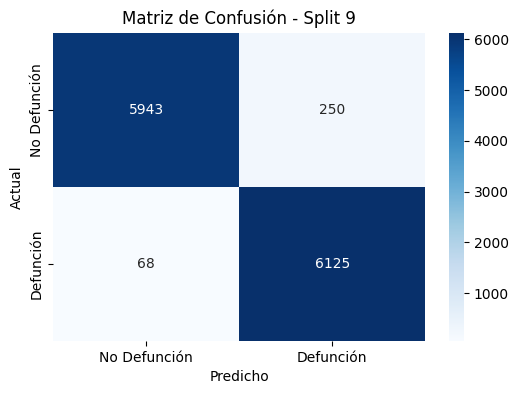

Scores para Clase 0 (Test):
  Precisión: 0.9887, Recall: 0.9596, F1-Score: 0.9739
Scores para Clase 1 (Test):
  Precisión: 0.9608, Recall: 0.9890, F1-Score: 0.9747


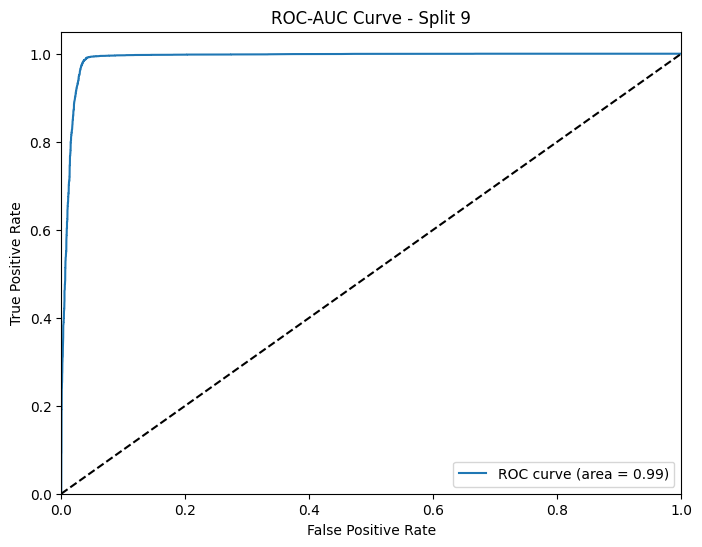


Evaluando el rendimiento para la División 10
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



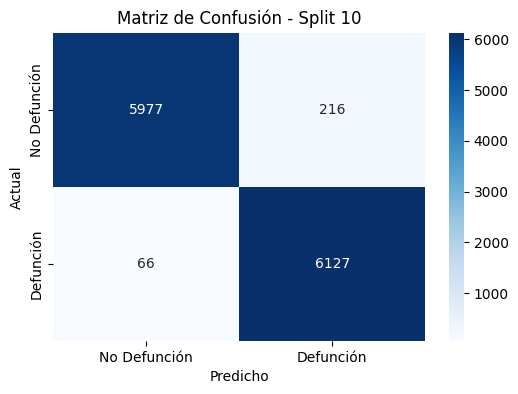

Scores para Clase 0 (Test):
  Precisión: 0.9891, Recall: 0.9651, F1-Score: 0.9770
Scores para Clase 1 (Test):
  Precisión: 0.9659, Recall: 0.9893, F1-Score: 0.9775


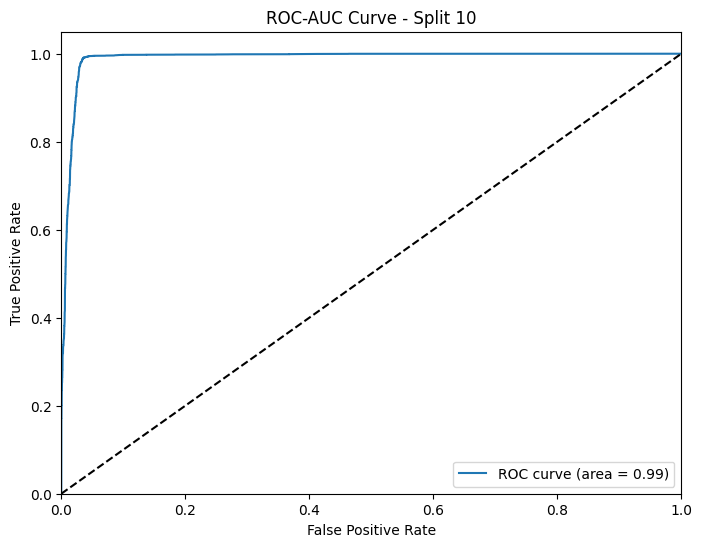


Evaluando el rendimiento para la División 11
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



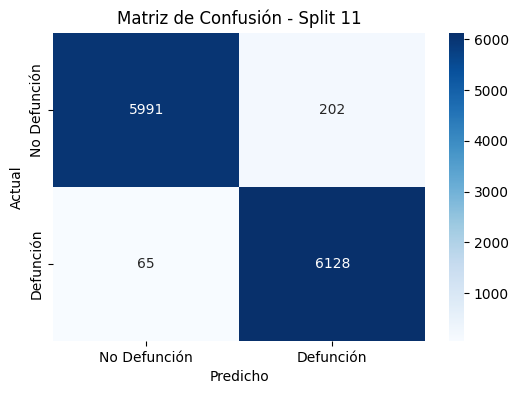

Scores para Clase 0 (Test):
  Precisión: 0.9893, Recall: 0.9674, F1-Score: 0.9782
Scores para Clase 1 (Test):
  Precisión: 0.9681, Recall: 0.9895, F1-Score: 0.9787


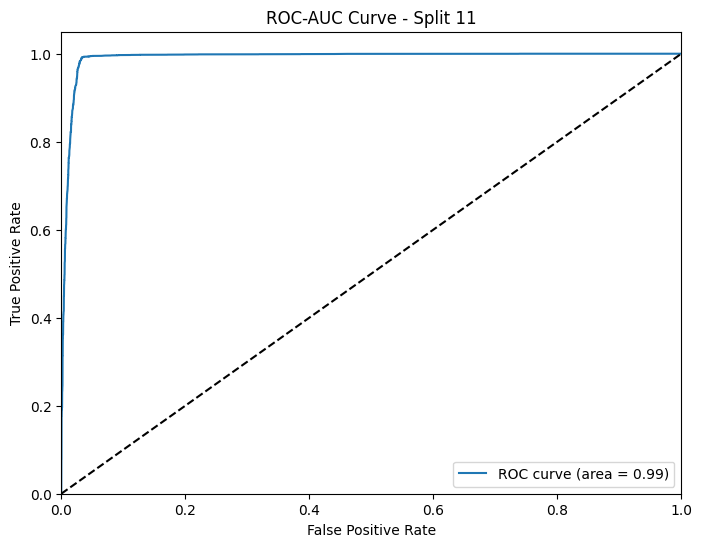


Evaluando el rendimiento para la División 12
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



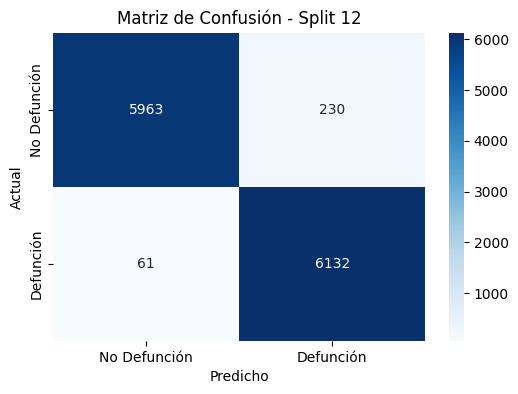

Scores para Clase 0 (Test):
  Precisión: 0.9899, Recall: 0.9629, F1-Score: 0.9762
Scores para Clase 1 (Test):
  Precisión: 0.9638, Recall: 0.9902, F1-Score: 0.9768


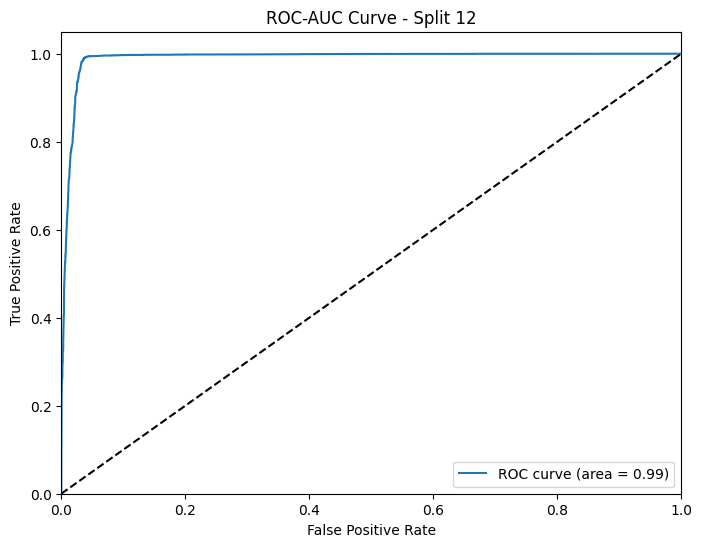


Evaluando el rendimiento para la División 13
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.97      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



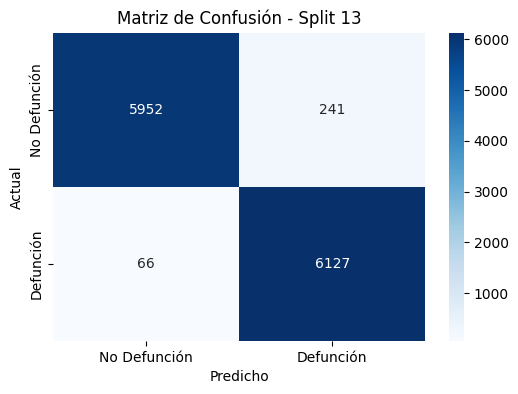

Scores para Clase 0 (Test):
  Precisión: 0.9890, Recall: 0.9611, F1-Score: 0.9749
Scores para Clase 1 (Test):
  Precisión: 0.9622, Recall: 0.9893, F1-Score: 0.9756


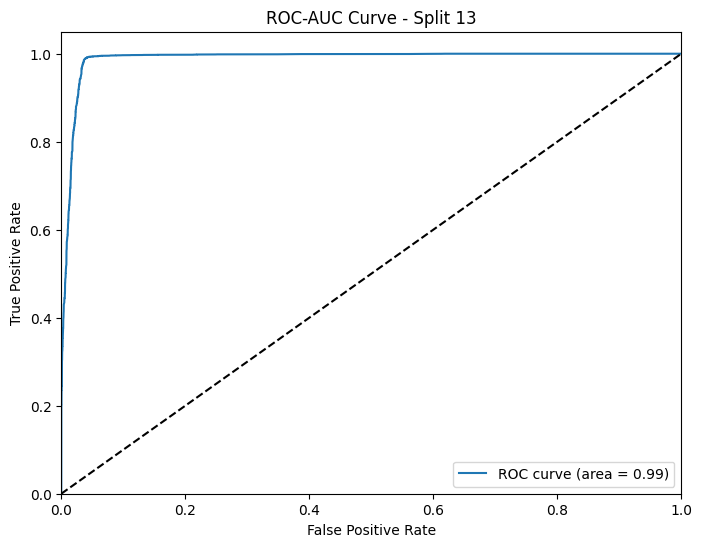


Evaluando el rendimiento para la División 14
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



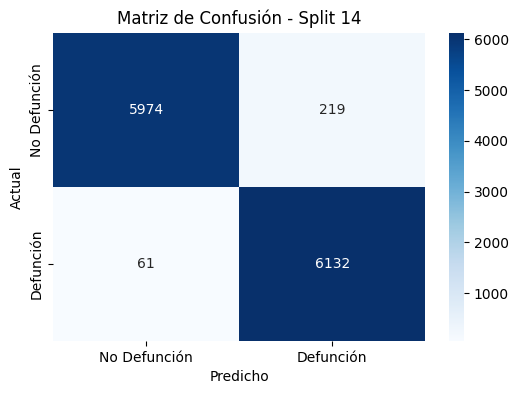

Scores para Clase 0 (Test):
  Precisión: 0.9899, Recall: 0.9646, F1-Score: 0.9771
Scores para Clase 1 (Test):
  Precisión: 0.9655, Recall: 0.9902, F1-Score: 0.9777


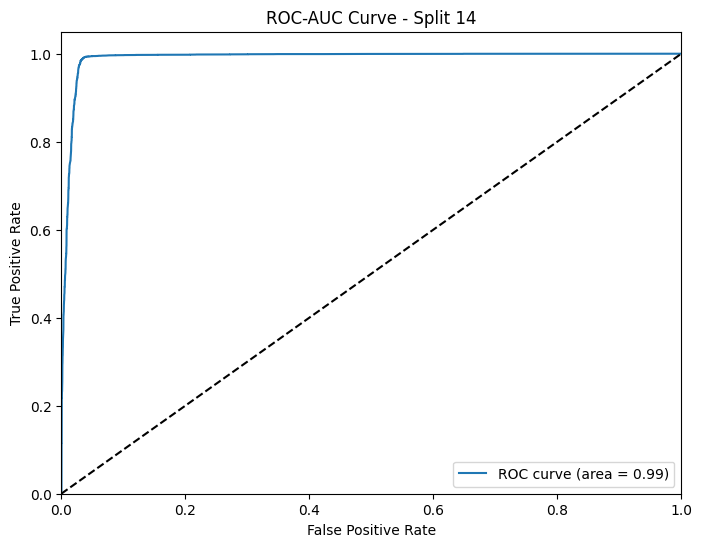


Evaluando el rendimiento para la División 15
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



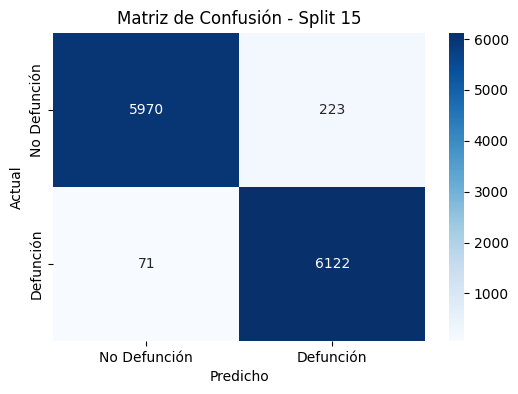

Scores para Clase 0 (Test):
  Precisión: 0.9882, Recall: 0.9640, F1-Score: 0.9760
Scores para Clase 1 (Test):
  Precisión: 0.9649, Recall: 0.9885, F1-Score: 0.9766


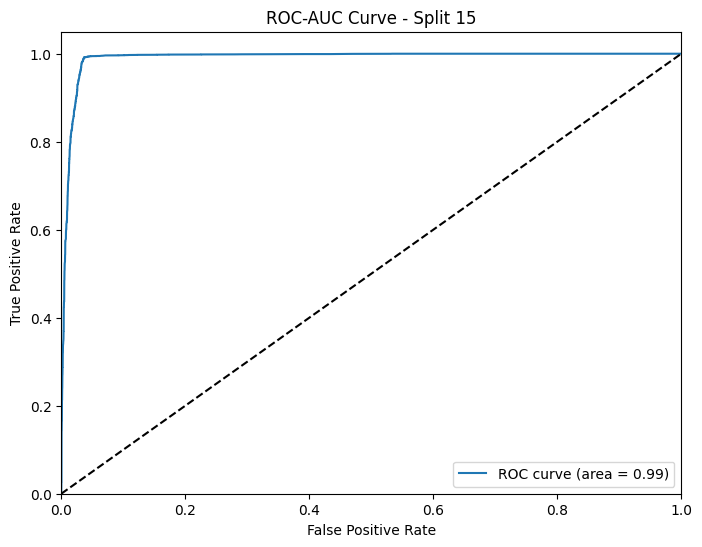


Evaluando el rendimiento para la División 16
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



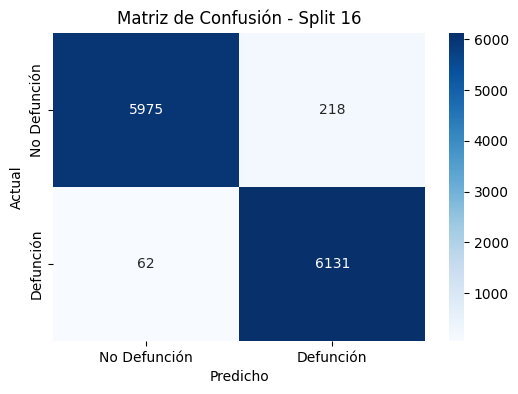

Scores para Clase 0 (Test):
  Precisión: 0.9897, Recall: 0.9648, F1-Score: 0.9771
Scores para Clase 1 (Test):
  Precisión: 0.9657, Recall: 0.9900, F1-Score: 0.9777


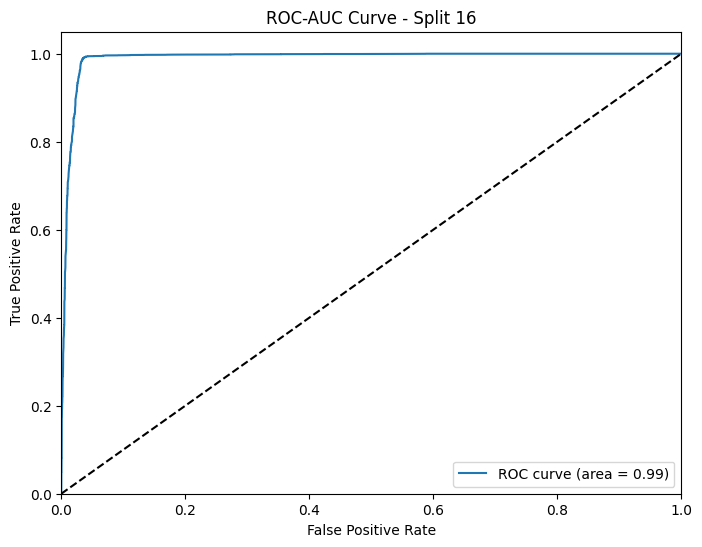


Evaluando el rendimiento para la División 17
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



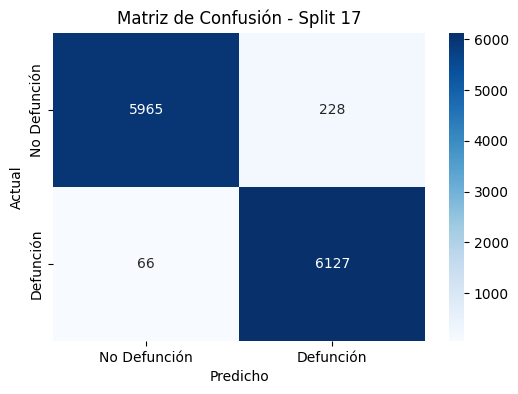

Scores para Clase 0 (Test):
  Precisión: 0.9891, Recall: 0.9632, F1-Score: 0.9759
Scores para Clase 1 (Test):
  Precisión: 0.9641, Recall: 0.9893, F1-Score: 0.9766


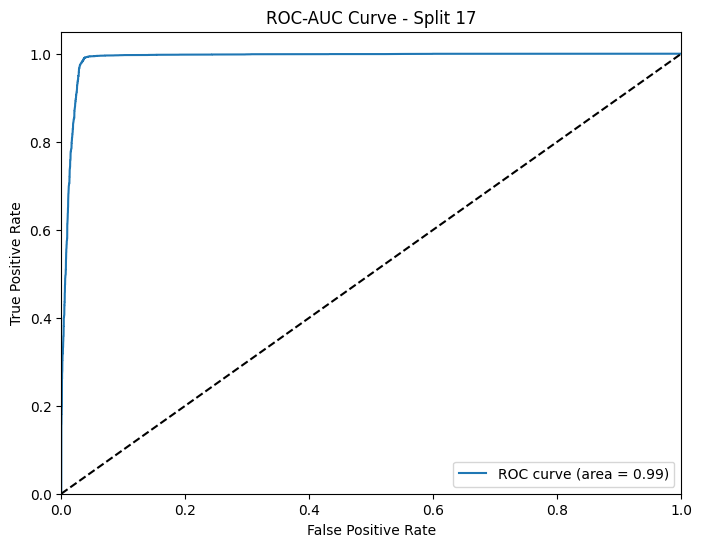


Evaluando el rendimiento para la División 18
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



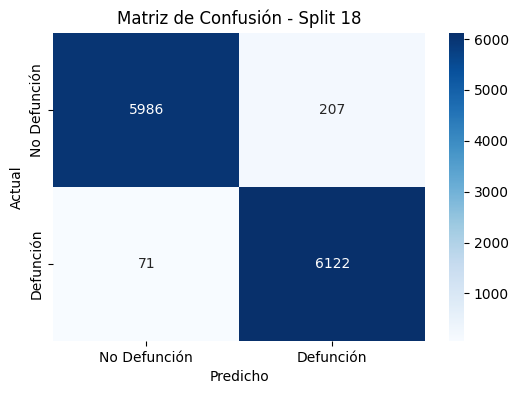

Scores para Clase 0 (Test):
  Precisión: 0.9883, Recall: 0.9666, F1-Score: 0.9773
Scores para Clase 1 (Test):
  Precisión: 0.9673, Recall: 0.9885, F1-Score: 0.9778


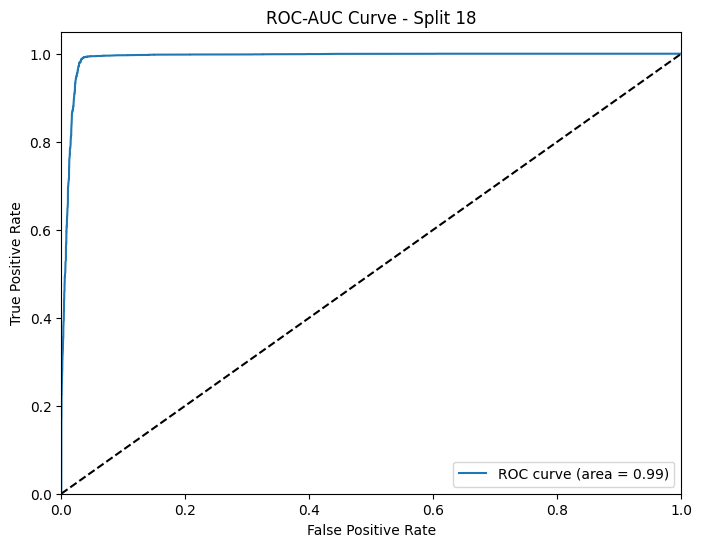


Evaluando el rendimiento para la División 19
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



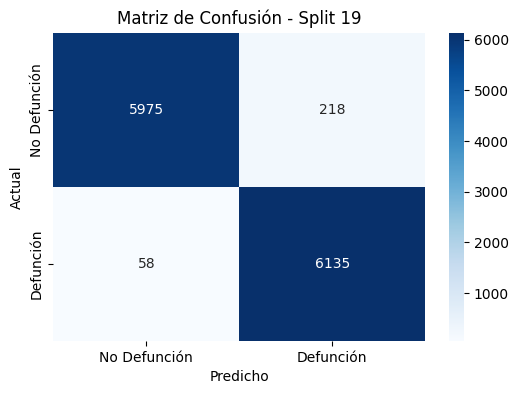

Scores para Clase 0 (Test):
  Precisión: 0.9904, Recall: 0.9648, F1-Score: 0.9774
Scores para Clase 1 (Test):
  Precisión: 0.9657, Recall: 0.9906, F1-Score: 0.9780


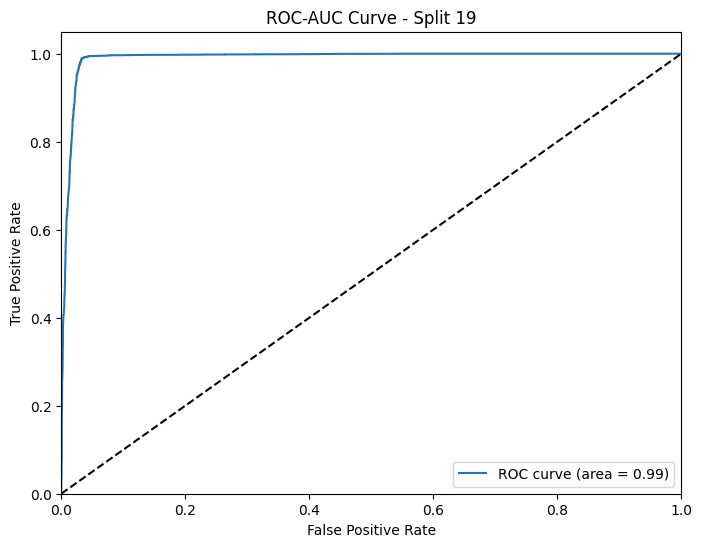


Evaluando el rendimiento para la División 20
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



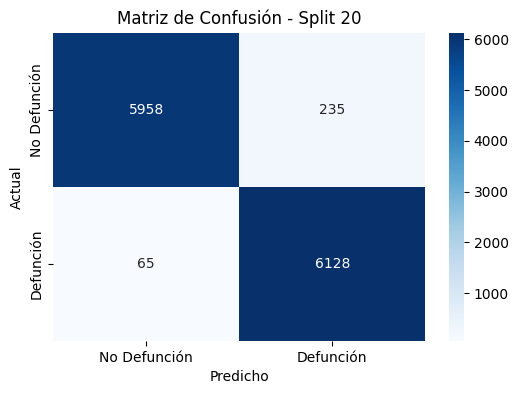

Scores para Clase 0 (Test):
  Precisión: 0.9892, Recall: 0.9621, F1-Score: 0.9754
Scores para Clase 1 (Test):
  Precisión: 0.9631, Recall: 0.9895, F1-Score: 0.9761


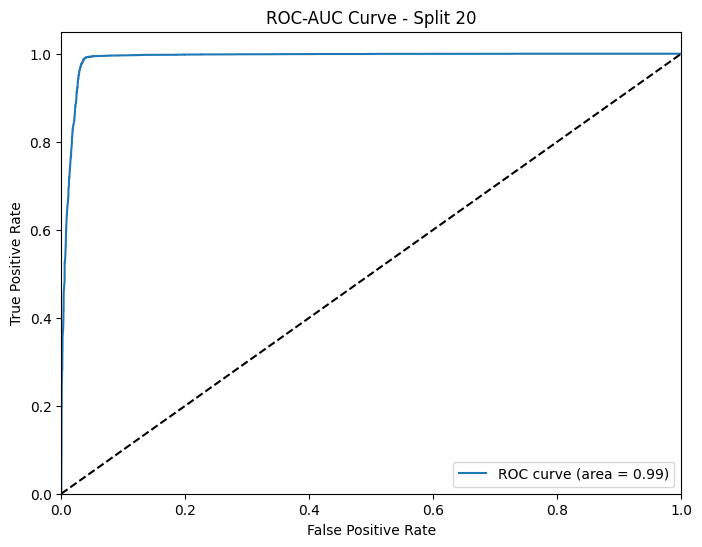


Evaluando el rendimiento para la División 21
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



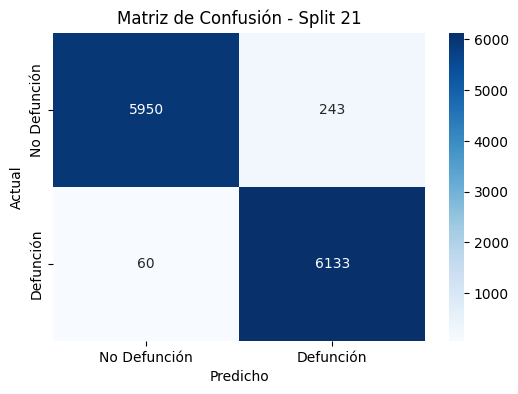

Scores para Clase 0 (Test):
  Precisión: 0.9900, Recall: 0.9608, F1-Score: 0.9752
Scores para Clase 1 (Test):
  Precisión: 0.9619, Recall: 0.9903, F1-Score: 0.9759


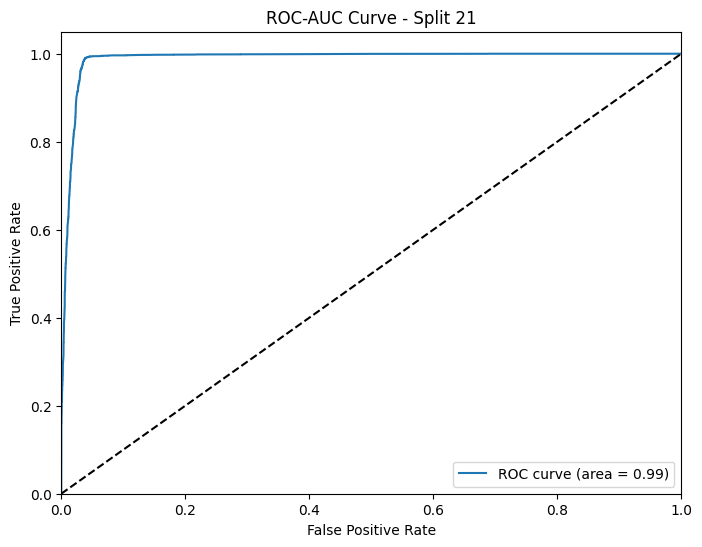


Evaluando el rendimiento para la División 22
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.97      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



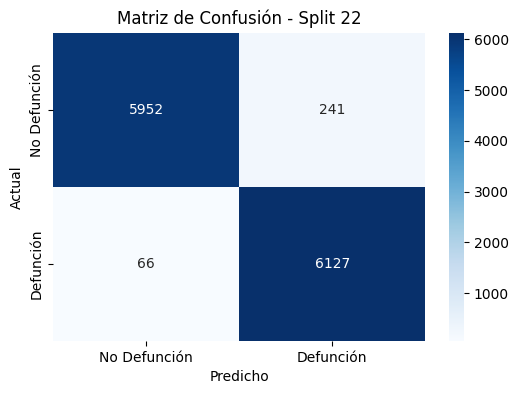

Scores para Clase 0 (Test):
  Precisión: 0.9890, Recall: 0.9611, F1-Score: 0.9749
Scores para Clase 1 (Test):
  Precisión: 0.9622, Recall: 0.9893, F1-Score: 0.9756


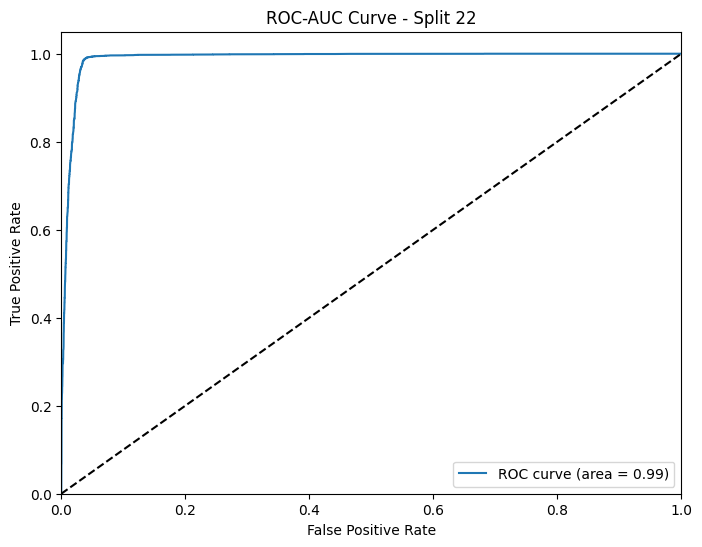


Evaluando el rendimiento para la División 23
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



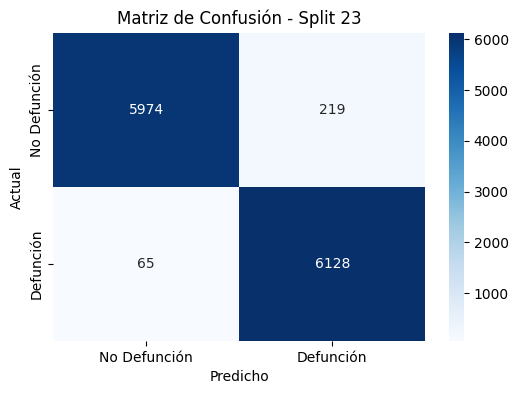

Scores para Clase 0 (Test):
  Precisión: 0.9892, Recall: 0.9646, F1-Score: 0.9768
Scores para Clase 1 (Test):
  Precisión: 0.9655, Recall: 0.9895, F1-Score: 0.9774


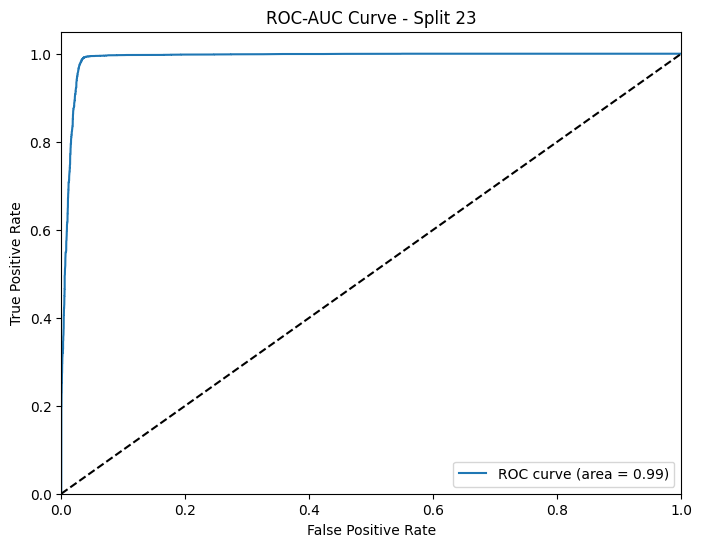


Evaluando el rendimiento para la División 24
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.97      6193
   Defunción       0.96      0.99      0.97      6193

    accuracy                           0.97     12386
   macro avg       0.97      0.97      0.97     12386
weighted avg       0.97      0.97      0.97     12386



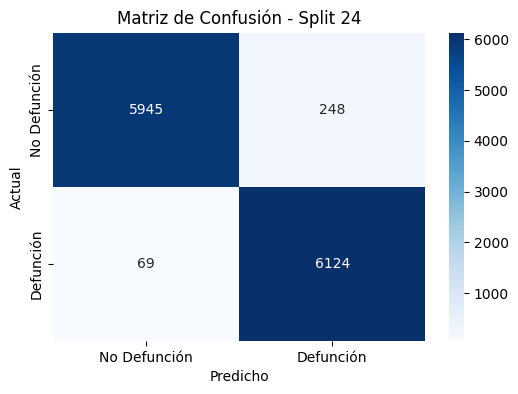

Scores para Clase 0 (Test):
  Precisión: 0.9885, Recall: 0.9600, F1-Score: 0.9740
Scores para Clase 1 (Test):
  Precisión: 0.9611, Recall: 0.9889, F1-Score: 0.9748


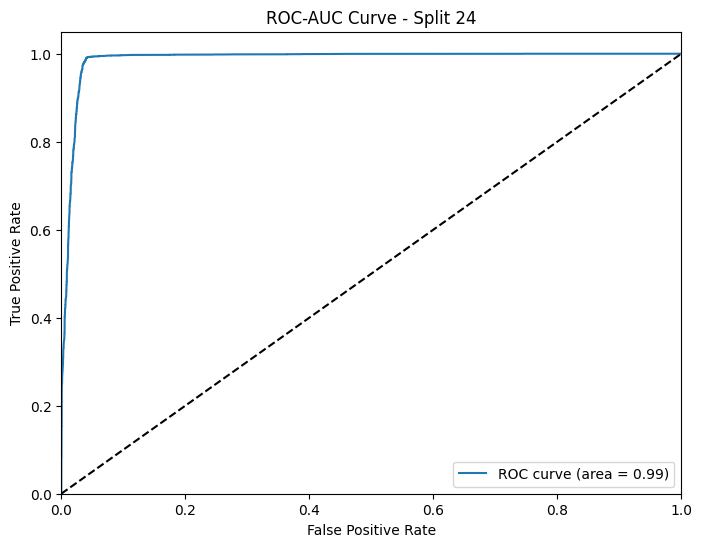


Evaluando el rendimiento para la División 25
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



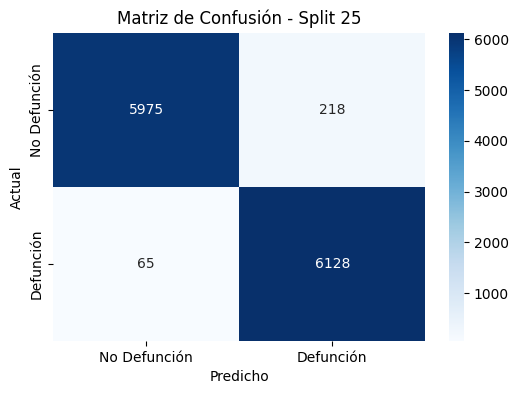

Scores para Clase 0 (Test):
  Precisión: 0.9892, Recall: 0.9648, F1-Score: 0.9769
Scores para Clase 1 (Test):
  Precisión: 0.9656, Recall: 0.9895, F1-Score: 0.9774


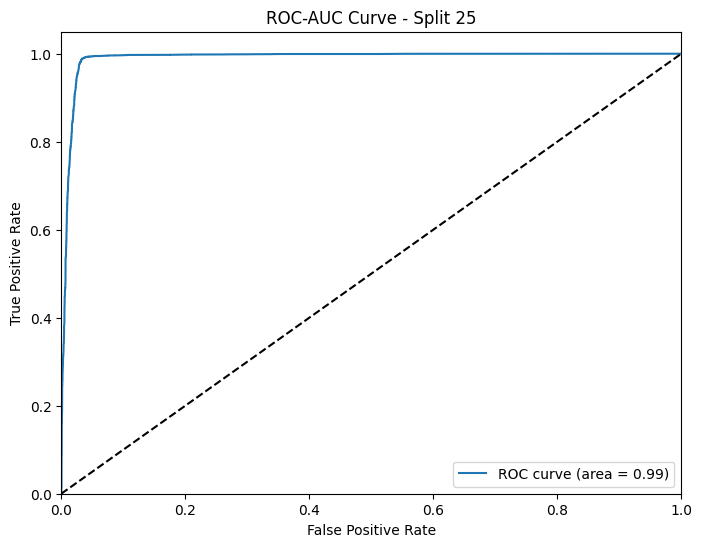


Evaluando el rendimiento para la División 26
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



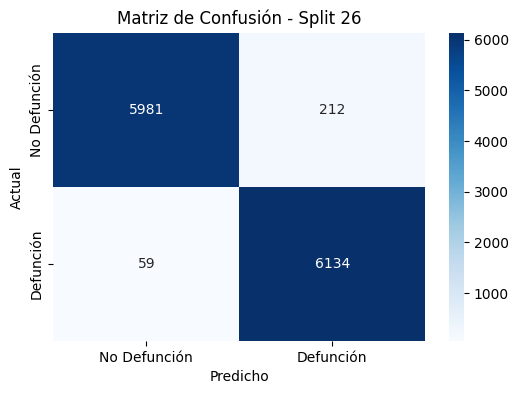

Scores para Clase 0 (Test):
  Precisión: 0.9902, Recall: 0.9658, F1-Score: 0.9778
Scores para Clase 1 (Test):
  Precisión: 0.9666, Recall: 0.9905, F1-Score: 0.9784


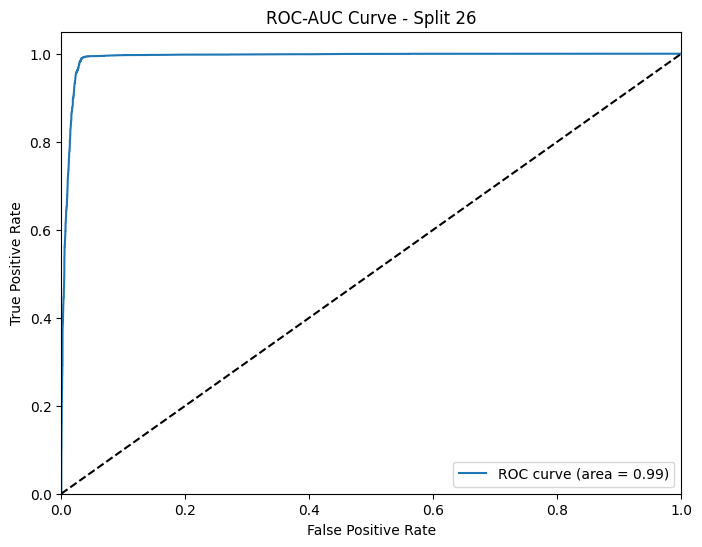


Evaluando el rendimiento para la División 27
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



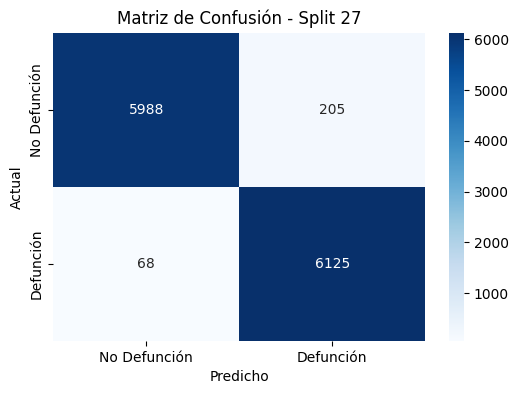

Scores para Clase 0 (Test):
  Precisión: 0.9888, Recall: 0.9669, F1-Score: 0.9777
Scores para Clase 1 (Test):
  Precisión: 0.9676, Recall: 0.9890, F1-Score: 0.9782


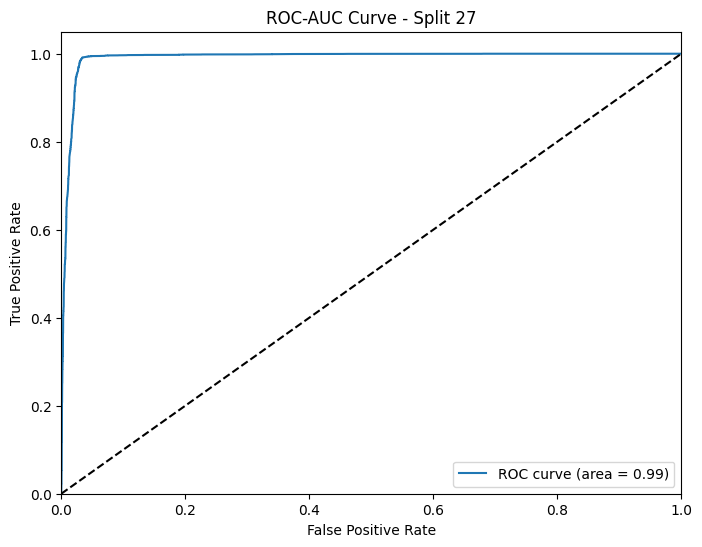


Evaluando el rendimiento para la División 28
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



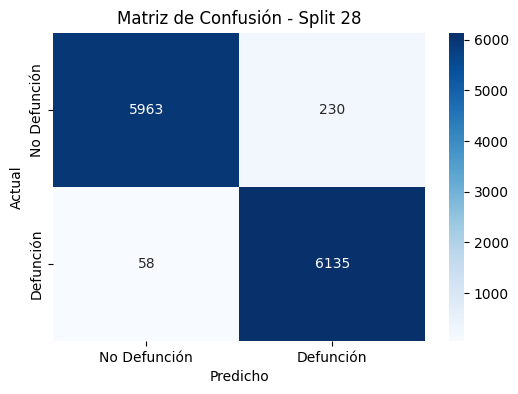

Scores para Clase 0 (Test):
  Precisión: 0.9904, Recall: 0.9629, F1-Score: 0.9764
Scores para Clase 1 (Test):
  Precisión: 0.9639, Recall: 0.9906, F1-Score: 0.9771


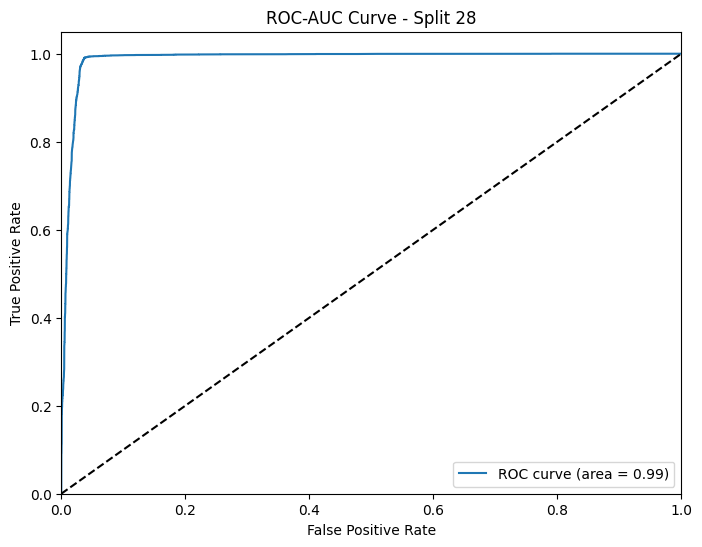


Evaluando el rendimiento para la División 29
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



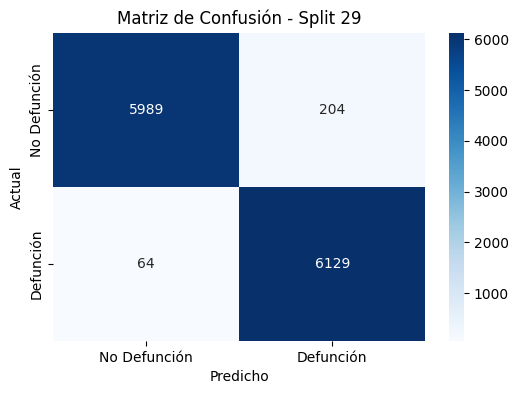

Scores para Clase 0 (Test):
  Precisión: 0.9894, Recall: 0.9671, F1-Score: 0.9781
Scores para Clase 1 (Test):
  Precisión: 0.9678, Recall: 0.9897, F1-Score: 0.9786


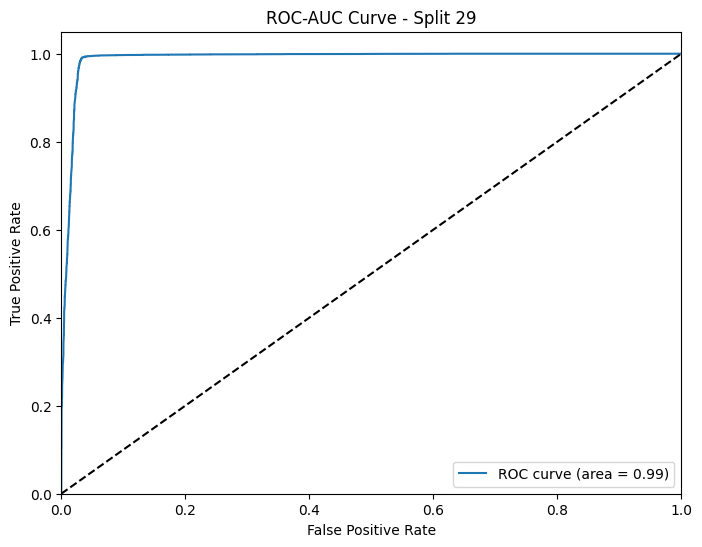


Evaluando el rendimiento para la División 30
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



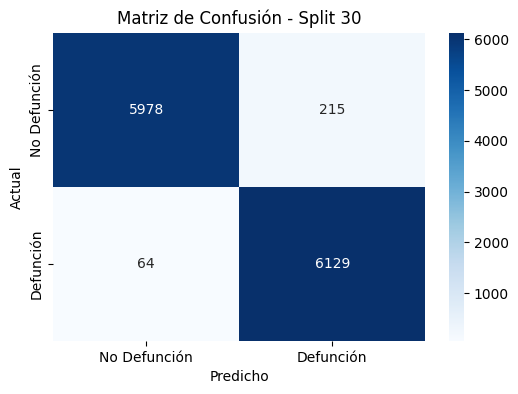

Scores para Clase 0 (Test):
  Precisión: 0.9894, Recall: 0.9653, F1-Score: 0.9772
Scores para Clase 1 (Test):
  Precisión: 0.9661, Recall: 0.9897, F1-Score: 0.9777


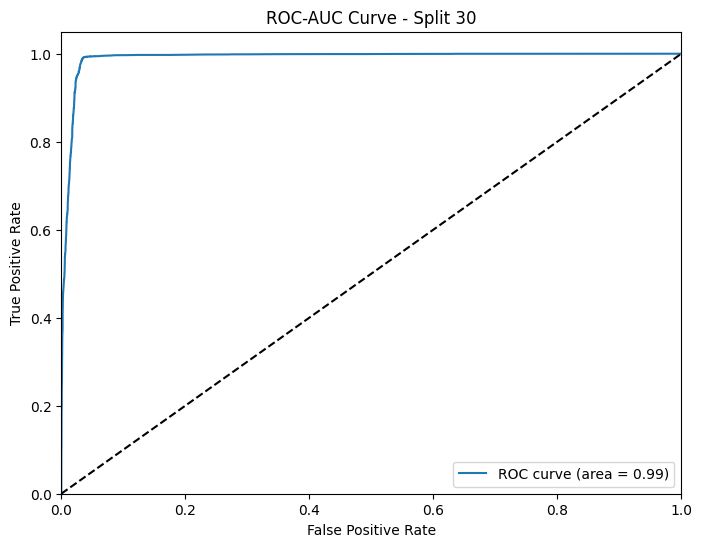


Evaluando el rendimiento para la División 31
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.97      0.98      6193
   Defunción       0.97      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



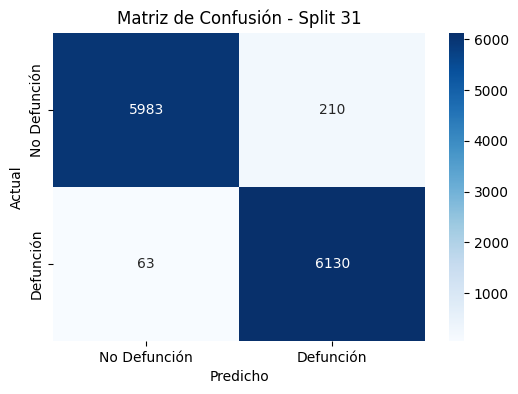

Scores para Clase 0 (Test):
  Precisión: 0.9896, Recall: 0.9661, F1-Score: 0.9777
Scores para Clase 1 (Test):
  Precisión: 0.9669, Recall: 0.9898, F1-Score: 0.9782


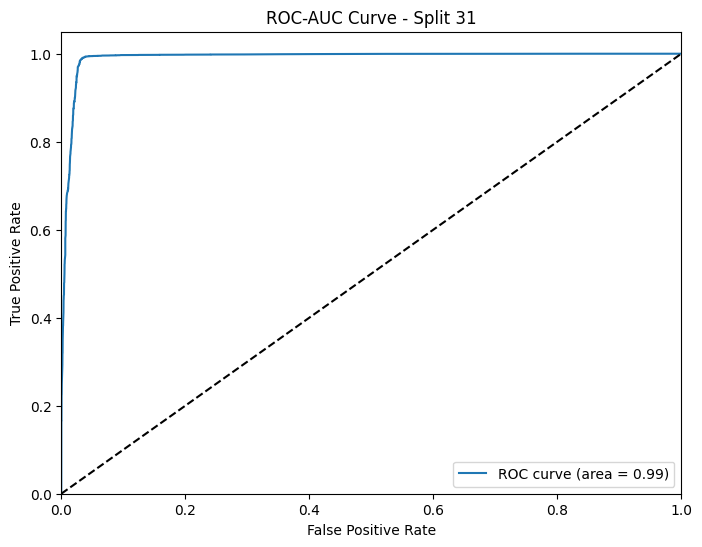


Evaluando el rendimiento para la División 32
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



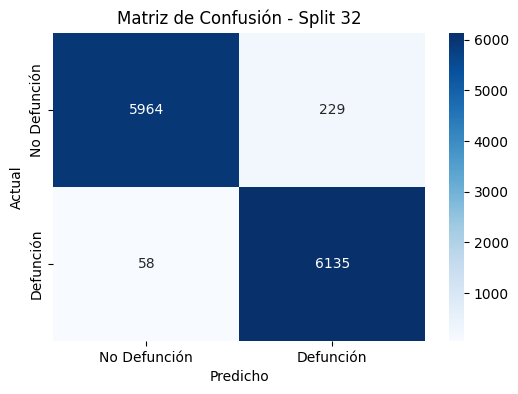

Scores para Clase 0 (Test):
  Precisión: 0.9904, Recall: 0.9630, F1-Score: 0.9765
Scores para Clase 1 (Test):
  Precisión: 0.9640, Recall: 0.9906, F1-Score: 0.9771


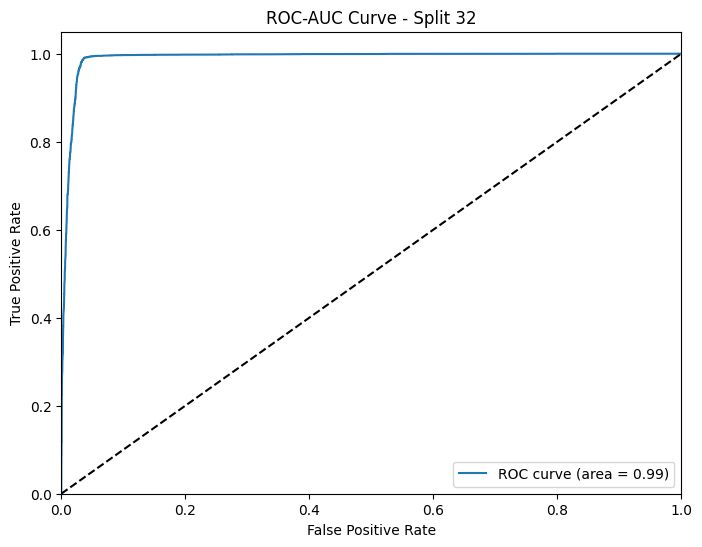


Evaluando el rendimiento para la División 33
Classification Report:
              precision    recall  f1-score   support

No Defunción       0.99      0.96      0.98      6193
   Defunción       0.96      0.99      0.98      6193

    accuracy                           0.98     12386
   macro avg       0.98      0.98      0.98     12386
weighted avg       0.98      0.98      0.98     12386



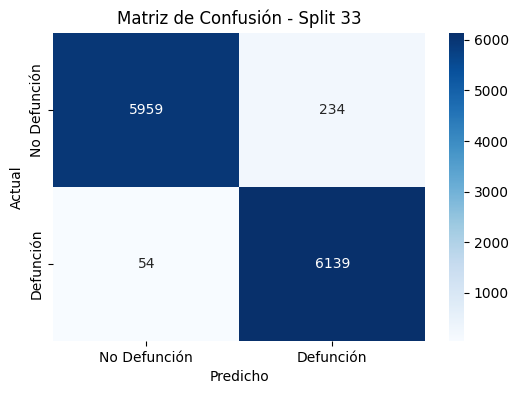

Scores para Clase 0 (Test):
  Precisión: 0.9910, Recall: 0.9622, F1-Score: 0.9764
Scores para Clase 1 (Test):
  Precisión: 0.9633, Recall: 0.9913, F1-Score: 0.9771


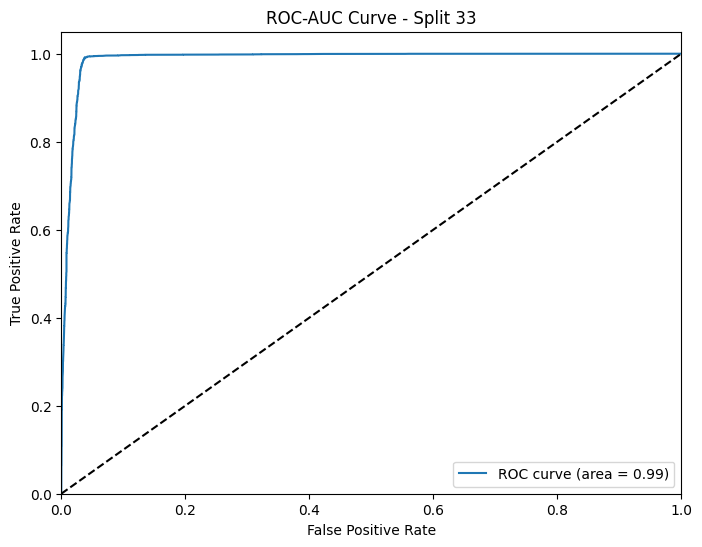

In [101]:
# Listas para almacenar los resultados de ambas clases y para ambos conjuntos
scores_train = {
    'Precision_class_0': [],
    'Recall_class_0': [],
    'F1_class_0': [],
    'AUC': [],
    'MCC': [],
    'Accuracy': [],
    'Precision_class_1': [],
    'Recall_class_1': [],
    'F1_class_1': [],
}


scores_test = {
    'Precision_class_0': [],
    'Recall_class_0': [],
    'F1_class_0': [],
    'AUC': [],
    'MCC': [],
    'Accuracy': [],
    'Precision_class_1': [],
    'Recall_class_1': [],
    'F1_class_1': [],
}


# Diccionarios para almacenar las variables menos importantes
least_important_features_gain = {}
least_important_features_weight = {}
least_important_features_coverage = {}


# Evaluación del modelo
for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']


    print(f"\nEvaluando el rendimiento para la División {idx + 1}")


    model = xgb.XGBClassifier(objective='binary:logistic',
                              scale_pos_weight=scale_pos_weight,
                              tree_method='hist', device='cuda',
                              random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])


    model.fit(X_train, y_train)


    # Predicciones y métricas para conjunto de prueba
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = model.predict(X_test)

    precision_0_test = precision_score(y_test, y_pred_test, pos_label=0)
    recall_0_test = recall_score(y_test, y_pred_test, pos_label=0)
    f1_0_test = f1_score(y_test, y_pred_test, pos_label=0)

    precision_1_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_1_test = recall_score(y_test, y_pred_test, pos_label=1)
    f1_1_test = f1_score(y_test, y_pred_test, pos_label=1)

    accuracy_test = accuracy_score(y_test, y_pred_test)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    

    scores_test['Precision_class_0'].append(precision_0_test)
    scores_test['Recall_class_0'].append(recall_0_test)
    scores_test['F1_class_0'].append(f1_0_test)
    scores_test['AUC'].append(roc_auc_score(y_test, y_pred_proba_test))
    scores_test['MCC'].append(mcc_test)
    scores_test['Accuracy'].append(accuracy_test)

    scores_test['Precision_class_1'].append(precision_1_test)
    scores_test['Recall_class_1'].append(recall_1_test)
    scores_test['F1_class_1'].append(f1_1_test)


    # Reporte de clasificación para el conjunto de prueba
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=["No Defunción", "Defunción"]))


    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Defunción", "Defunción"],
                yticklabels=["No Defunción", "Defunción"])
    plt.title(f"Matriz de Confusión - Split {idx + 1}")
    plt.ylabel('Actual')
    plt.xlabel('Predicho')
    plt.show()

    # Imprimir los scores de ambas clases
    print(f"Scores para Clase 0 (Test):")
    print(f"  Precisión: {precision_0_test:.4f}, Recall: {recall_0_test:.4f}, F1-Score: {f1_0_test:.4f}")

    print(f"Scores para Clase 1 (Test):")
    print(f"  Precisión: {precision_1_test:.4f}, Recall: {recall_1_test:.4f}, F1-Score: {f1_1_test:.4f}")
    

    # Curva ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
    auc = roc_auc_score(y_test, y_pred_proba_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve - Split {idx + 1}')
    plt.legend(loc="lower right")
    plt.show()


    # Predicciones y métricas para conjunto de entrenamiento
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_train = model.predict(X_train)


    scores_train['Precision_class_0'].append(precision_score(y_train, y_pred_train, pos_label=0))
    scores_train['Recall_class_0'].append(recall_score(y_train, y_pred_train, pos_label=0))
    scores_train['F1_class_0'].append(f1_score(y_train, y_pred_train, pos_label=0))
    scores_train['AUC'].append(roc_auc_score(y_train, y_pred_proba_train))

    scores_train['Precision_class_1'].append(precision_score(y_train, y_pred_train, pos_label=1))
    scores_train['Recall_class_1'].append(recall_score(y_train, y_pred_train, pos_label=1))
    scores_train['F1_class_1'].append(f1_score(y_train, y_pred_train, pos_label=1))

    accuracy_train = accuracy_score(y_train, y_pred_train)
    scores_train['Accuracy'].append(accuracy_train)

    mcc_train = matthews_corrcoef(y_train, y_pred_train)
    scores_train['MCC'].append(mcc_train)


    # Obtener la importancia de las características
    importance_gain = model.get_booster().get_score(importance_type='gain')
    importance_weight = model.get_booster().get_score(importance_type='weight')
    importance_coverage = model.get_booster().get_score(importance_type='cover')


    # Convertir la importancia a DataFrames para ordenarlas y seleccionar las 10 menos importantes
    importance_gain_df = pd.DataFrame(list(importance_gain.items()), columns=['Feature', 'Gain']).sort_values(by='Gain')
    importance_weight_df = pd.DataFrame(list(importance_weight.items()), columns=['Feature', 'Weight']).sort_values(by='Weight')
    importance_coverage_df = pd.DataFrame(list(importance_coverage.items()), columns=['Feature', 'Coverage']).sort_values(by='Coverage')


    # Seleccionar las 10 variables menos importantes
    least_important_gain = importance_gain_df.head(10)['Feature'].tolist()
    least_important_weight = importance_weight_df.head(10)['Feature'].tolist()
    least_important_coverage = importance_coverage_df.head(10)['Feature'].tolist()


    # Almacenar las variables menos importantes en los diccionarios
    least_important_features_gain[f'Division_{idx + 1}'] = least_important_gain
    least_important_features_weight[f'Division_{idx + 1}'] = least_important_weight
    least_important_features_coverage[f'Division_{idx + 1}'] = least_important_coverage

Desviación estándar para el conjunto de entrenamiento:
Precision_class_0    0.000371
Recall_class_0       0.000953
F1_class_0           0.000531
Precision_class_1    0.000899
Recall_class_1       0.000365
F1_class_1           0.000501
AUC                  0.000417
MCC                  0.001014
Accuracy             0.000516
dtype: float64
Desviación estándar para el conjunto de prueba:
Precision_class_0    0.000686
Recall_class_0       0.002267
F1_class_0           0.001182
Precision_class_1    0.002130
Recall_class_1       0.000677
F1_class_1           0.001105
AUC                  0.000835
MCC                  0.002237
Accuracy             0.001143
dtype: float64


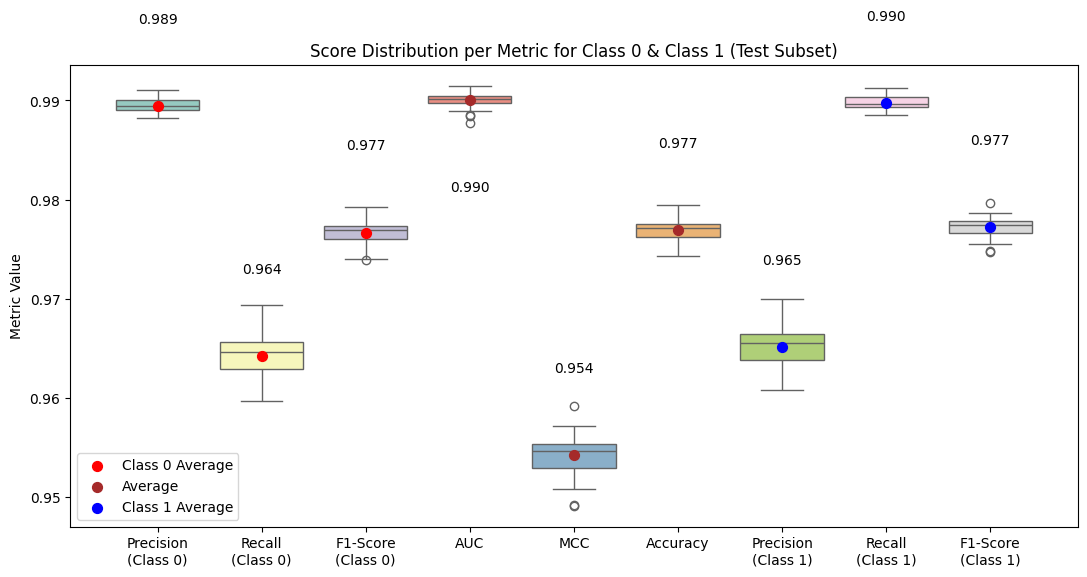

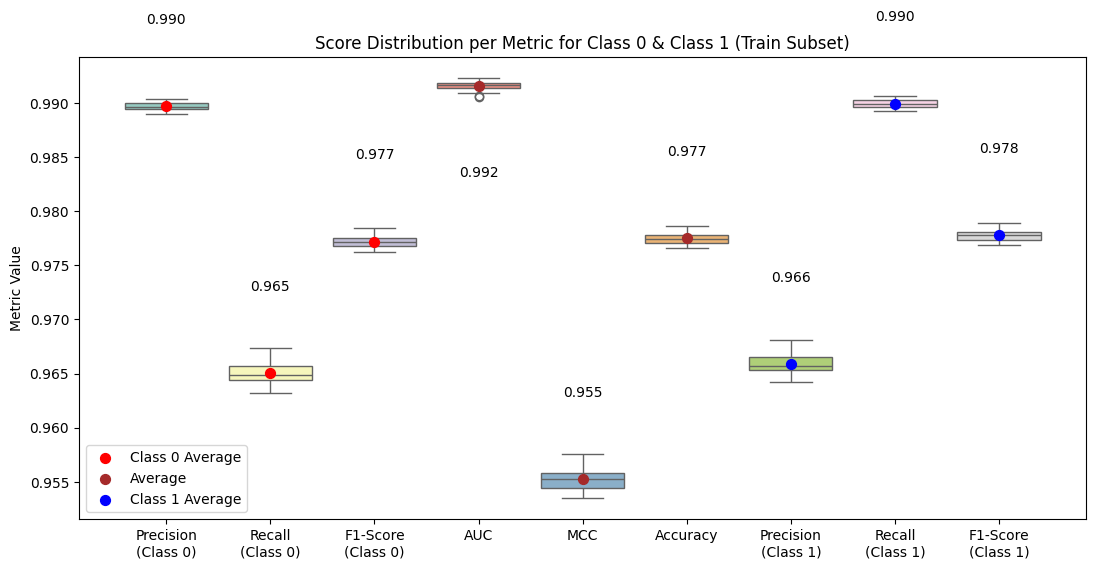

In [102]:
# Crear DataFrames para los resultados de entrenamiento y prueba
df_scores_train = pd.DataFrame(scores_train)
df_scores_test = pd.DataFrame(scores_test)

# Desviación estándar para métricas específicas en el conjunto de entrenamiento
std_train_selected = df_scores_train[['Precision_class_0', 'Recall_class_0', 'F1_class_0', 
                                      'Precision_class_1', 'Recall_class_1', 'F1_class_1', 
                                      'AUC', 'MCC', 'Accuracy']].std()
print("Desviación estándar para el conjunto de entrenamiento:")
print(std_train_selected)

# Desviación estándar para métricas específicas en el conjunto de prueba
std_test_selected = df_scores_test[['Precision_class_0', 'Recall_class_0', 'F1_class_0', 
                                    'Precision_class_1', 'Recall_class_1', 'F1_class_1', 
                                    'AUC', 'MCC', 'Accuracy']].std()
print("Desviación estándar para el conjunto de prueba:")
print(std_test_selected)

# Función para crear boxplots con promedios
def boxplot_metricas(df_scores, title, palette="Set3"):
    plt.figure(figsize=(13, 6))
    sns.boxplot(data=df_scores, palette=palette)

    # Calcular los promedios
    avg_precision_0 = np.mean(df_scores['Precision_class_0'])
    avg_recall_0 = np.mean(df_scores['Recall_class_0'])
    avg_f1_0 = np.mean(df_scores['F1_class_0'])

    avg_precision_1 = np.mean(df_scores['Precision_class_1'])
    avg_recall_1 = np.mean(df_scores['Recall_class_1'])
    avg_f1_1 = np.mean(df_scores['F1_class_1'])

    avg_auc = np.mean(df_scores['AUC'])
    avg_accuracy = np.mean(df_scores['Accuracy'])
    avg_mcc = np.mean(df_scores['MCC']) 

    # Añadir los puntos de los promedios en el boxplot
    plt.scatter(x=[0, 1, 2], y=[avg_precision_0, avg_recall_0, avg_f1_0], 
                color='red', label='Class 0 Average', zorder=5, s=50)
    plt.scatter(x=[3, 4, 5], y=[avg_auc, avg_mcc, avg_accuracy], 
                color='brown', label='Average', zorder=5, s=50)
    plt.scatter(x=[6, 7, 8], y=[avg_precision_1, avg_recall_1, avg_f1_1], 
                color='blue', label='Class 1 Average', zorder=5, s=50)

    # Valores numéricos
    for i, avg in enumerate([avg_precision_0, avg_recall_0, avg_f1_0,
                             avg_auc, avg_mcc, avg_accuracy, 
                             avg_precision_1, avg_recall_1, avg_f1_1]):


        y_offset = 0.19 * (df_scores.max().max() - df_scores.min().min()) 

        # Condición para avg_auc
        if i == 3:  # Índice para AUC
            plt.text(i, avg - y_offset, f'{avg:.3f}', color='black', ha='center', va='top', fontsize=10)
        else:
            plt.text(i, avg + y_offset, f'{avg:.3f}', color='black', ha='center', va='bottom', fontsize=10)

    # Etiquetas y título
    plt.title(title)
    plt.ylabel('Metric Value')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['Precision\n(Class 0)', 'Recall\n(Class 0)', 'F1-Score\n(Class 0)',
                                             'AUC', 'MCC', 'Accuracy',
                                             'Precision\n(Class 1)', 'Recall\n(Class 1)', 'F1-Score\n(Class 1)'])
    plt.legend()

    plt.show()

# Graficar métricas para conjunto de prueba
boxplot_metricas(df_scores_test, 'Score Distribution per Metric for Class 0 & Class 1 (Test Subset)')

# Graficar métricas para conjunto de entrenamiento
boxplot_metricas(df_scores_train, 'Score Distribution per Metric for Class 0 & Class 1 (Train Subset)')

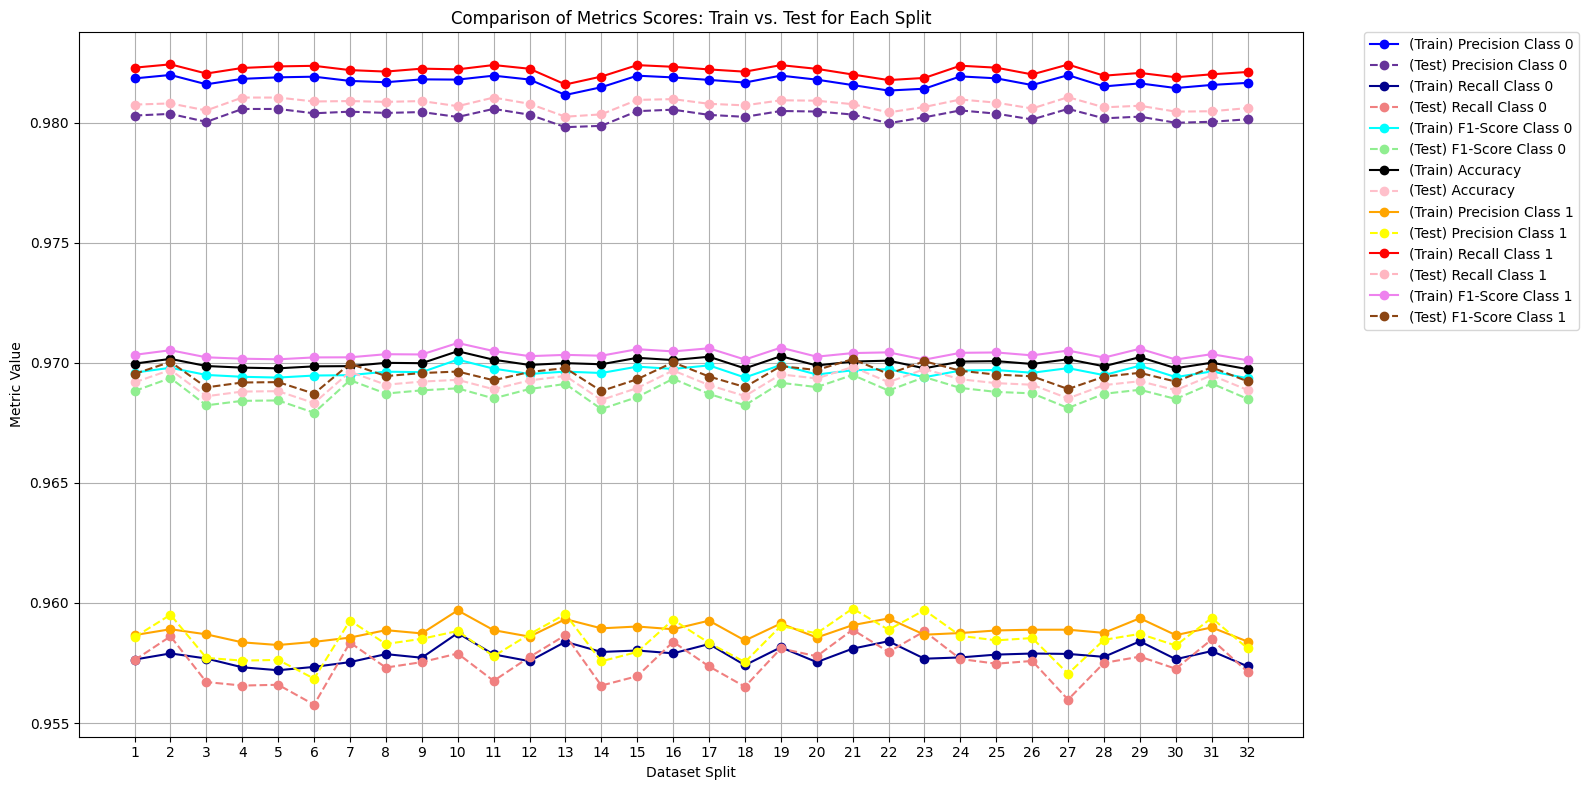

In [42]:
def line_chart_metrics(scores_train, scores_test, title):
    # Número de divisiones (splits)
    num_splits = len(scores_train['Precision_class_0'])

    x = np.arange(1, num_splits + 1)

    # Crear el gráfico
    plt.figure(figsize=(16, 8))

    # Graficar las métricas para clase 0
    plt.plot(x, [np.mean(scores_train['Precision_class_0'][i]) for i in range(num_splits)], marker='o', label='(Train) Precision Class 0', color='blue')
    plt.plot(x, [np.mean(scores_test['Precision_class_0'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) Precision Class 0', color='rebeccapurple')

    plt.plot(x, [np.mean(scores_train['Recall_class_0'][i]) for i in range(num_splits)], marker='o', label='(Train) Recall Class 0', color='darkblue')
    plt.plot(x, [np.mean(scores_test['Recall_class_0'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) Recall Class 0', color='lightcoral')

    plt.plot(x, [np.mean(scores_train['F1_class_0'][i]) for i in range(num_splits)], marker='o', label='(Train) F1-Score Class 0', color='cyan')
    plt.plot(x, [np.mean(scores_test['F1_class_0'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) F1-Score Class 0', color='lightgreen')

    # Graficar Accuracy
    plt.plot(x, [np.mean(scores_train['Accuracy'][i]) for i in range(num_splits)], marker='o', label='(Train) Accuracy', color='black')
    plt.plot(x, [np.mean(scores_test['Accuracy'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) Accuracy', color='pink')

    # Graficar las métricas para clase 1
    plt.plot(x, [np.mean(scores_train['Precision_class_1'][i]) for i in range(num_splits)], marker='o', label='(Train) Precision Class 1', color='orange')
    plt.plot(x, [np.mean(scores_test['Precision_class_1'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) Precision Class 1', color='yellow')

    plt.plot(x, [np.mean(scores_train['Recall_class_1'][i]) for i in range(num_splits)], marker='o', label='(Train) Recall Class 1', color='red')
    plt.plot(x, [np.mean(scores_test['Recall_class_1'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) Recall Class 1', color='lightpink')

    plt.plot(x, [np.mean(scores_train['F1_class_1'][i]) for i in range(num_splits)], marker='o', label='(Train) F1-Score Class 1', color='violet')
    plt.plot(x, [np.mean(scores_test['F1_class_1'][i]) for i in range(num_splits)], marker='o', linestyle='--', label='(Test) F1-Score Class 1', color='saddlebrown')


    plt.title(title)
    plt.xlabel('Dataset Split')
    plt.ylabel('Metric Value')
    plt.xticks(x)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid()

    plt.tight_layout()
    plt.show()

line_chart_metrics(scores_train, scores_test, 'Comparison of Metrics Scores: Train vs. Test for Each Split')


# **Resultados**

In [ ]:
# Diccionarios para almacenar las veces que cada variable aparece entre las más o menos importantes según XGBoost
contador_menos_importantes_xgb = defaultdict(lambda: {'gain': 0, 'weight': 0, 'cover': 0})
contador_mas_importantes_xgb = defaultdict(lambda: {'gain': 0, 'weight': 0, 'cover': 0})

# Diccionarios para contar la frecuencia de las 25 más y 10 menos importantes según SHAP
contador_mas_importantes_shap = defaultdict(int)
contador_menos_importantes_shap = defaultdict(int)

# Lista para almacenar los resultados de SHAP
shap_results = []

# Diccionario para almacenar los resultados de correlación punto biserial
correlation_results = defaultdict(list)

# Iteración sobre los splits del dataset
for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']

    print(f"\nEvaluando el rendimiento para la División {idx + 1}")

    # Inicializar el modelo con los mejores parámetros para la división actual
    model = xgb.XGBClassifier(objective='binary:logistic',
                              scale_pos_weight=scale_pos_weight,
                              tree_method='hist', device='cuda',
                              random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])

    # Ajustar el modelo
    model.fit(X_train, y_train)

    # Obtener los scores de las métricas de XGB
    importancia_gain = model.get_booster().get_score(importance_type='gain')
    importancia_weight = model.get_booster().get_score(importance_type='weight')
    importancia_cover = model.get_booster().get_score(importance_type='cover')

    # Obtener las 10 variables más importantes
    mas_importantes_gain = sorted(importancia_gain, key=importancia_gain.get, reverse=True)[:20]
    mas_importantes_weight = sorted(importancia_weight, key=importancia_weight.get, reverse=True)[:20]
    mas_importantes_cover = sorted(importancia_cover, key=importancia_cover.get, reverse=True)[:20]

    # Obtener las 10 variables menos importantes
    menos_importantes_gain = sorted(importancia_gain, key=importancia_gain.get)[:10]
    menos_importantes_weight = sorted(importancia_weight, key=importancia_weight.get)[:10]
    menos_importantes_cover = sorted(importancia_cover, key=importancia_cover.get)[:10]

    # Actualizar los contadores de variables más importantes según XGBoost
    for variable in mas_importantes_gain:
        contador_mas_importantes_xgb[variable]['gain'] += 1
    for variable in mas_importantes_weight:
        contador_mas_importantes_xgb[variable]['weight'] += 1
    for variable in mas_importantes_cover:
        contador_mas_importantes_xgb[variable]['cover'] += 1

    # Actualizar los contadores de variables menos importantes según XGBoost
    for variable in menos_importantes_gain:
        contador_menos_importantes_xgb[variable]['gain'] += 1
    for variable in menos_importantes_weight:
        contador_menos_importantes_xgb[variable]['weight'] += 1
    for variable in menos_importantes_cover:
        contador_menos_importantes_xgb[variable]['cover'] += 1

    # Crear el objeto explainer de SHAP y obtener los SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    # Gráfico de resumen (summary plot)
    #plt.figure(figsize=(10, 6))
    #shap.summary_plot(shap_values, X_test, max_display=25, show=False)
    #plt.title('SHAP Summary Plot')
    #plt.show()

    # Almacenar los valores SHAP de esta división
    shap_results.append(shap_values.values)

    # Obtener el valor promedio absoluto de los SHAP values por variable
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)

    # Variables más importantes según SHAP
    mas_importantes_shap = np.argsort(-mean_shap_values)[:30]
    for var_idx in mas_importantes_shap:
        variable_name = X_test.columns[var_idx]
        contador_mas_importantes_shap[variable_name] += 1

    # Variables menos importantes según SHAP
    menos_importantes_shap = np.argsort(mean_shap_values)[:10]
    for var_idx in menos_importantes_shap:
        variable_name = X_test.columns[var_idx]
        contador_menos_importantes_shap[variable_name] += 1

    # Calcular correlación punto biserial con los valores SHAP
    shap_df = pd.DataFrame(shap_values.values, columns=[f'shap_{col}' for col in X_test.columns])
    shap_df['DEFUNCION'] = y_test.reset_index(drop=True)
    
    # Calcular la correlación punto biserial
    shap_columns = [col for col in shap_df.columns if col.startswith('shap_')]
    for column in shap_columns:
        if shap_df[column].nunique() <= 1:
            print(f"La columna {column} es constante; no se puede calcular la correlación.")
            continue  # Saltar al siguiente ciclo del bucle
        try:
            corr, _ = pointbiserialr(shap_df['DEFUNCION'], shap_df[column])
            correlation_results[column] = corr
        except ValueError as e:
            print(f"Error al calcular la correlación para {column}: {e}")

# Promediar las correlaciones al final de todas las iteraciones
promedio_correlaciones = {
    "Variable": [],
    "Correlación Promedio": []
}

for variable, correlations in correlation_results.items():
    avg_corr = np.mean(correlations)  # Promediar las correlaciones para cada variable
    promedio_correlaciones["Variable"].append(variable)
    promedio_correlaciones["Correlación Promedio"].append(avg_corr)

# Crear el DataFrame con las correlaciones promediadas
correlation_df = pd.DataFrame(promedio_correlaciones)

# Ordenar el DataFrame por la correlación absoluta
correlation_df_sorted = correlation_df.reindex(correlation_df['Correlación Promedio'].abs().sort_values(ascending=False).index)



# Convertir los diccionarios de XGBoost a DataFrames

df_mas_importantes_xgb = pd.DataFrame(contador_mas_importantes_xgb).T.reset_index()
df_mas_importantes_xgb.columns = ['Variable', 'Gain', 'Weight', 'Cover']
df_mas_importantes_xgb = df_mas_importantes_xgb[(df_mas_importantes_xgb['Gain'] > 0) | 
                                                (df_mas_importantes_xgb['Weight'] > 0) | 
                                                (df_mas_importantes_xgb['Cover'] > 0)]

df_menos_importantes_xgb = pd.DataFrame(contador_menos_importantes_xgb).T.reset_index()
df_menos_importantes_xgb.columns = ['Variable', 'Gain', 'Weight', 'Cover']
df_menos_importantes_xgb = df_menos_importantes_xgb[(df_menos_importantes_xgb['Gain'] > 0) | 
                                                    (df_menos_importantes_xgb['Weight'] > 0) | 
                                                    (df_menos_importantes_xgb['Cover'] > 0)]

# Convertir los resultados de SHAP a DataFrames
df_menos_importantes_shap = pd.DataFrame(contador_menos_importantes_shap.items(), columns=['Variable', 'Frecuencia'])
df_menos_importantes_shap = df_menos_importantes_shap[df_menos_importantes_shap['Frecuencia'] > 0]

df_mas_importantes_shap = pd.DataFrame(contador_mas_importantes_shap.items(), columns=['Variable', 'Frecuencia'])
df_mas_importantes_shap = df_mas_importantes_shap[df_mas_importantes_shap['Frecuencia'] > 0]

# Convertir resultados de correlación a DataFrame
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Variable', 'Correlación'])
correlation_df_sorted = correlation_df.reindex(correlation_df['Correlación'].abs().sort_values(ascending=False).index)

# Gráficas

# Gráfico de barras apiladas para las métricas de XGBoost (más importantes)
df_mas_importantes_xgb.set_index('Variable').plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightcoral', 'skyblue', 'lightgreen'])
#plt.title('Most Important Features Frequency according to XGBoost Metrics (Gain, Weight, Cover)')
plt.xlabel('Feature')
plt.ylabel('Number of Appearances Within the\nTop 20 Most Relevant')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

# Gráfico de barras apiladas para las métricas de XGBoost (menos importantes)
df_menos_importantes_xgb.set_index('Variable').plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightcoral', 'skyblue', 'lightgreen'])
#plt.title('Least Important Features Frequency according to XGBoost Metrics (Gain, Weight, Cover)')
plt.xlabel('Feature')
plt.ylabel('Number of Appearances Within the\n Top 10 Least Relevant')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

# Gráfico de barras para las variables más importantes según SHAP
df_mas_importantes_shap_sorted = df_mas_importantes_shap.sort_values(by='Frecuencia', ascending=False)
df_mas_importantes_shap_sorted = df_mas_importantes_shap_sorted.rename(columns={'Frecuencia': 'Frequency'})
df_mas_importantes_shap_sorted.set_index('Variable').plot(kind='bar', figsize=(10, 6), color='olivedrab')
#plt.title('Most Important Features Frequency according to SHAP')
plt.xlabel('Feature')
plt.ylabel('Number of Appearances Within the\n Top 30 Most Relevant')
plt.tight_layout()
plt.show()

# Gráfico de barras para las variables menos importantes según SHAP
df_menos_importantes_shap_sorted = df_menos_importantes_shap.sort_values(by='Frecuencia', ascending=False)
df_menos_importantes_shap_sorted = df_menos_importantes_shap_sorted.rename(columns={'Frecuencia': 'Frequency'})
df_menos_importantes_shap_sorted.set_index('Variable').plot(kind='bar', figsize=(10, 6), color='lightcoral')
#plt.title('Least Important Features Frequency according to SHAP')
plt.xlabel('Feature')
plt.ylabel('Number of Appearances Within the\n Top 10 Least Relevant')
plt.tight_layout()
plt.show()

# Eliminar el prefijo 'shap_' de las variables en la columna 'Variable'
correlation_df_sorted['Variable'] = correlation_df_sorted['Variable'].str.replace('shap_', '', regex=False)

# Visualización de la correlación punto biserial
plt.figure(figsize=(10, 12))
sns.barplot(x='Correlación', y='Variable', data=correlation_df_sorted)
plt.axvline(0, color='gray', linestyle='--')
#plt.title('Point-Biserial Correlation between SHAP Values and DECEASED')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Diccionario para almacenar el ranking de las variables por división
shap_ranking_por_division = {}

# Iteración sobre los splits del dataset
for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']

    print(f"\nEvaluando el rendimiento para la División {idx + 1}")

    # Inicializar el modelo con los mejores parámetros para la división actual
    model = xgb.XGBClassifier(objective='binary:logistic',
                              scale_pos_weight=scale_pos_weight,
                              tree_method='hist', device='cuda',
                              random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])

    # Ajustar el modelo
    model.fit(X_train, y_train)

    # Crear el objeto explainer de SHAP y obtener los SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    # Obtener el valor promedio absoluto de los SHAP values por variable
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)

    # Variables más importantes según SHAP
    mas_importantes_shap = np.argsort(-mean_shap_values)[:30]

    # Crear un ranking de las variables para la división actual
    ranking_actual = {X_test.columns[var_idx]: rank + 1 for rank, var_idx in enumerate(mas_importantes_shap)}

    # Agregar el ranking al diccionario
    shap_ranking_por_division[f'Division_{idx + 1}'] = ranking_actual

# Convertir el diccionario a un DataFrame
df_shap_ranking = pd.DataFrame(shap_ranking_por_division).fillna(np.nan)

# Opcional: Ordenar las variables alfabéticamente
df_shap_ranking = df_shap_ranking.sort_index()

# Mostrar el DataFrame resultante
print("\nRanking de variables por SHAP Summary Plot:")
print(df_shap_ranking)

In [ ]:
# Seleccionamos un split aleatorio, por ejemplo, el primero
split_inicial = 4
top_30_variables = df_shap_ranking.iloc[:, split_inicial].nsmallest(30).index

# Filtramos el DataFrame original para que solo incluya las 30 variables seleccionadas
df_top_30 = df_shap_ranking.loc[top_30_variables]

# Aseguramos que las posiciones de las variables que no aparecen en un split sean NaN
df_top_30 = df_top_30.replace(0, np.nan)

In [ ]:
plt.figure(figsize=(11, 8))
ax = sns.heatmap(df_top_30, annot=True, fmt=".0f", cmap="coolwarm", cbar=True, cbar_kws={'pad': 0.01},
                 linewidths=0.5, linecolor='gray', annot_kws={'size': 11},
                 xticklabels=[f"{i+1}" for i in range(df_shap_ranking.shape[1])], yticklabels=df_top_30.index)

ax.tick_params(axis='x', labelsize=11)  
ax.tick_params(axis='y', labelsize=11)  

cbar = ax.collections[0].colorbar
cbar.ax.invert_yaxis()
cbar.ax.set_aspect(1)
plt.subplots_adjust(right=0.2)
cbar.ax.set_position([0.005, 0.05, 0.00002, 0.07]) 

plt.xlabel("Splits", fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\super\OneDrive\Documentos\Code\Python\ML\ProyectoCOVID\modelos\Lib\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


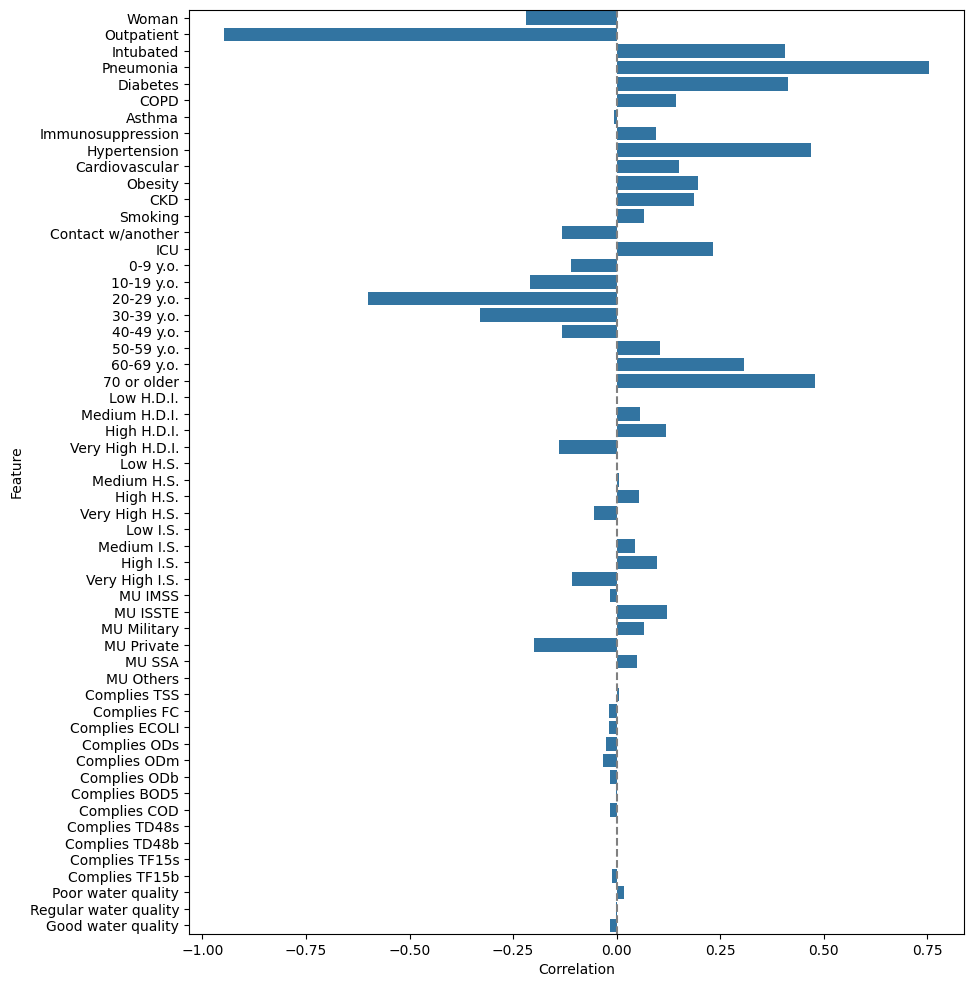

In [ ]:
# Inicializa la lista para almacenar resultados de SHAP
shap_results = []

for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']

    # print(f"\nEntrenando el modelo para la División {idx + 1}")

    # Inicializar el modelo con los mejores parámetros
    model = xgb.XGBClassifier(objective='binary:logistic', tree_method='hist', device='cuda', random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])  # Usar los mejores parámetros
    
    model.fit(X_train, y_train)

    # Guardar el modelo entrenado con un nombre único para cada división
    # model_filename = f"LENTIC_xgb_model_division_{idx + 1}.pkl"
    # joblib.dump(model, model_filename)  # Guardar el modelo

    # Crear el explainer de SHAP
    explainer = shap.TreeExplainer(model)

    # Obtener los valores SHAP para el conjunto de prueba
    shap_values = explainer.shap_values(X_test)

    # Almacenar los valores SHAP y las características originales en un DataFrame
    shap_df = pd.DataFrame(shap_values, columns=[f'shap_{col}' for col in X_test.columns])
    shap_df['shap_sum'] = shap_values.sum(axis=1)

    # Concatenar los valores SHAP con las características originales
    shap_df = pd.concat([shap_df, X_test.reset_index(drop=True)], axis=1)

    # Agregar los resultados de SHAP a la lista
    shap_results.append(shap_df)


# Para concatenar resultados de todas las divisiones
all_shap_results = pd.concat(shap_results, ignore_index=True)

# Calcular correlación punto biserial
correlation_results = {}

# Solo tomar columnas numéricas para la correlación
num_columns = all_shap_results.select_dtypes(include=['int64', 'float64']).columns

for column in num_columns:
    if column != 'shap_sum':  # Evitar la columna de suma de SHAP
        try:
            corr, _ = pointbiserialr(all_shap_results['shap_sum'], all_shap_results[column])
            correlation_results[column] = corr
        except ValueError as e:
            print(f"Error al calcular la correlación para {column}: {e}")

# Convertir resultados de correlación a DataFrame
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Variable', 'Correlación'])

# Visualizar correlaciones

plt.figure(figsize=(10, 12))
sns.barplot(x='Correlación', y='Variable', data=correlation_df)
plt.axvline(0, color='gray', linestyle='--')
#plt.title('Point-Biserial Correlation between SHAP Values and Features\nShows the Trend of a Variable as Protection or Risk Factor')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()

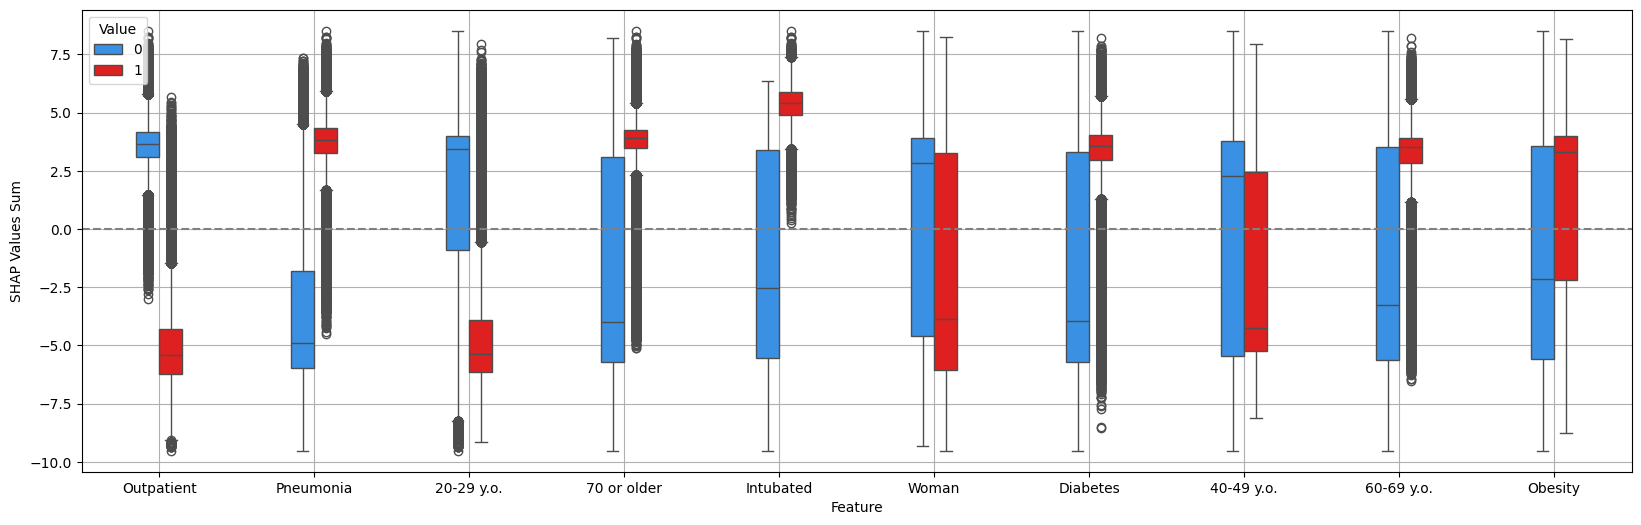

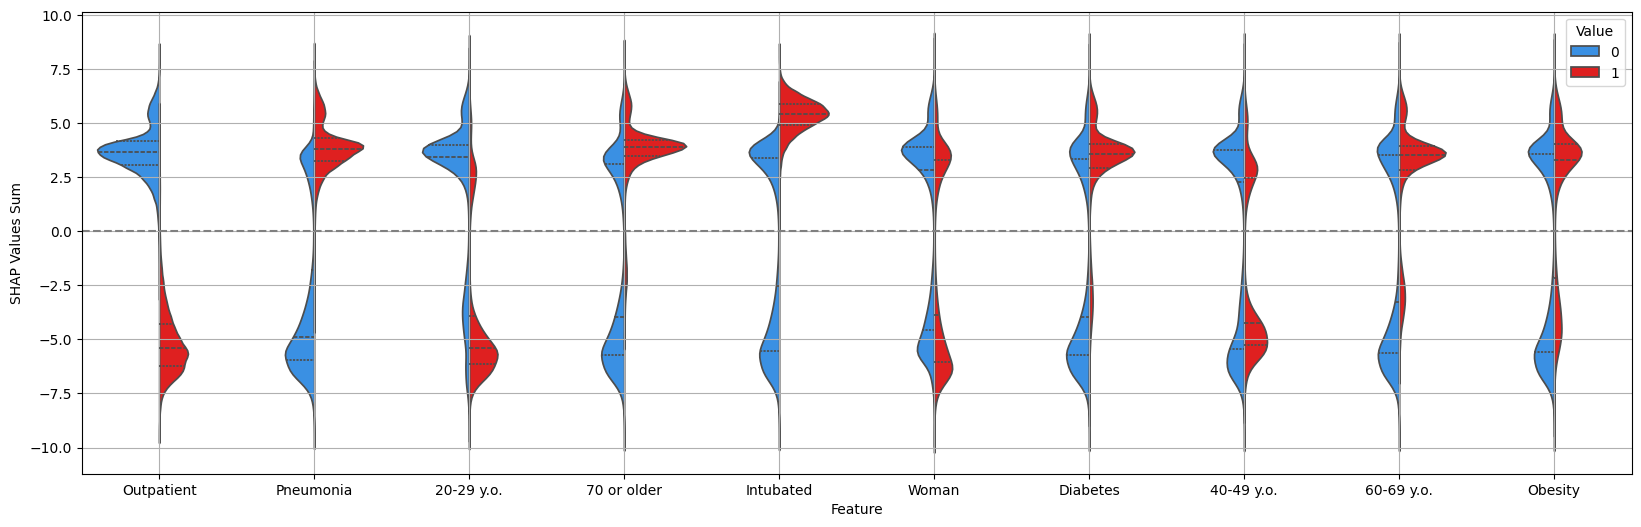

Variable: Outpatient | U-statistic (greater): 140067680941.0 | p-value (greater): 0.0 | Interpretación (greater): diferencias significativas (mayor riesgo con la característica)
Variable: Outpatient | U-statistic (less): 140067680941.0 | p-value (less): 1.0 | Interpretación (less): no hay diferencias significativas (menor riesgo con la característica)
Variable: Pneumonia | U-statistic (greater): 8236005790.0 | p-value (greater): 1.0 | Interpretación (greater): no hay diferencias significativas (mayor riesgo con la característica)
Variable: Pneumonia | U-statistic (less): 8236005790.0 | p-value (less): 0.0 | Interpretación (less): diferencias significativas (menor riesgo con la característica)
Variable: 20-29 y.o. | U-statistic (greater): 117187818825.5 | p-value (greater): 0.0 | Interpretación (greater): diferencias significativas (mayor riesgo con la característica)
Variable: 20-29 y.o. | U-statistic (less): 117187818825.5 | p-value (less): 1.0 | Interpretación (less): no hay diferenc

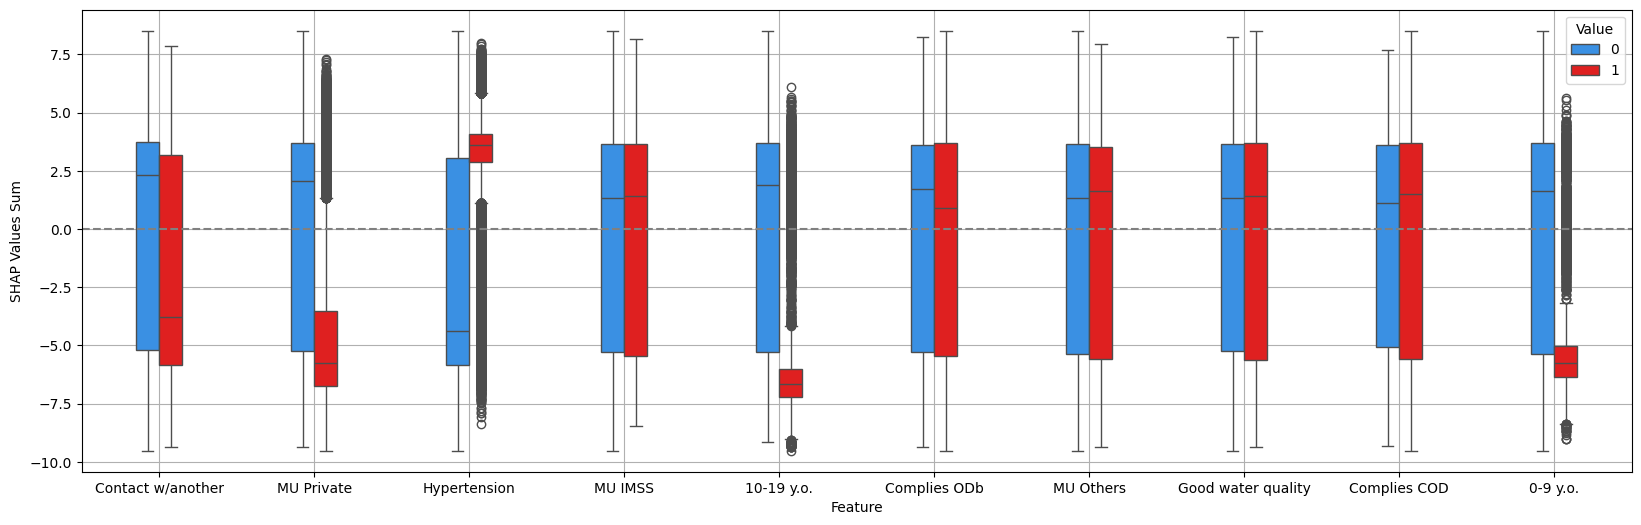

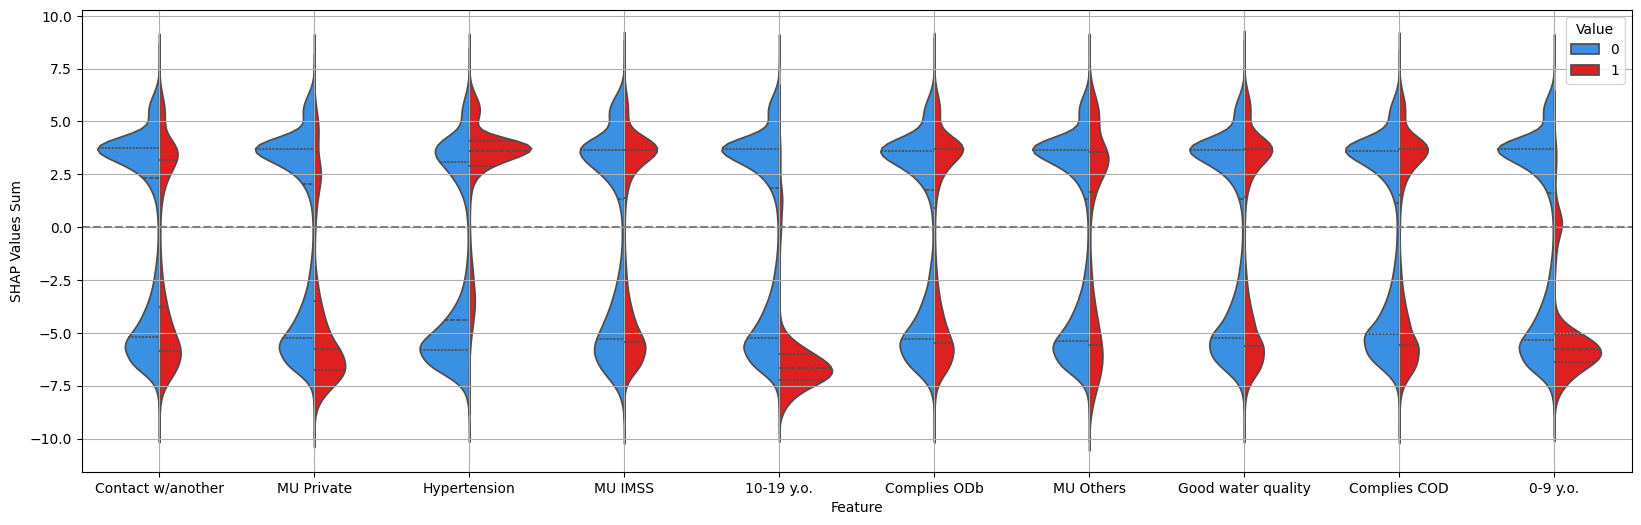

Variable: Contact w/another | U-statistic (greater): 61520328851.5 | p-value (greater): 0.0 | Interpretación (greater): diferencias significativas (mayor riesgo con la característica)
Variable: Contact w/another | U-statistic (less): 61520328851.5 | p-value (less): 1.0 | Interpretación (less): no hay diferencias significativas (menor riesgo con la característica)
Variable: MU Private | U-statistic (greater): 24762003786.0 | p-value (greater): 0.0 | Interpretación (greater): diferencias significativas (mayor riesgo con la característica)
Variable: MU Private | U-statistic (less): 24762003786.0 | p-value (less): 1.0 | Interpretación (less): no hay diferencias significativas (menor riesgo con la característica)
Variable: Hypertension | U-statistic (greater): 23111629052.5 | p-value (greater): 1.0 | Interpretación (greater): no hay diferencias significativas (mayor riesgo con la característica)
Variable: Hypertension | U-statistic (less): 23111629052.5 | p-value (less): 0.0 | Interpretació

In [43]:
caracteristicas_acopladas = df_mas_importantes_shap_sorted['Variable'].head(20).tolist()

grupo1 = caracteristicas_acopladas[:10]
grupo2 = caracteristicas_acopladas[10:]

def boxplots_tendencia(grupo):
    subconjunto = all_shap_results[['shap_sum'] + grupo]

    # Transformar el DataFrame usando melt
    melted_df = pd.melt(subconjunto, id_vars='shap_sum', value_vars=grupo, 
                        var_name='Variable', value_name='Value')

    plt.figure(figsize=(20, 6))
    palette = {0: 'dodgerblue', 1: 'red'}

    # Graficar boxplots
    sns.boxplot(data=melted_df, x='Variable', y='shap_sum', hue='Value',
                palette=palette, width=0.3)
    #plt.title('Distribution of Each Feature Values vs. SHAP')
    plt.xlabel('Feature')
    plt.ylabel('SHAP Values Sum')
    plt.axhline(0, color='gray', linestyle='--')  # Línea horizontal en 0
    plt.grid()
    plt.show()

    # Gráficos de violín
    plt.figure(figsize=(20, 6))
    sns.violinplot(data=melted_df, x='Variable', y='shap_sum', hue='Value',
                   palette=palette, split=True, inner='quartile')
    
    #plt.title('Distribution of Each Feature Values vs. SHAP')
    plt.xlabel('Feature')
    plt.ylabel('SHAP Values Sum')
    plt.axhline(0, color='gray', linestyle='--')  # Línea horizontal en 0
    plt.grid()
    plt.show()

    # Prueba U de Mann-Whitney
    results = []

    for variable in grupo:
        grupo_0 = melted_df[melted_df['Variable'] == variable].loc[melted_df['Value'] == 0, 'shap_sum']
        grupo_1 = melted_df[melted_df['Variable'] == variable].loc[melted_df['Value'] == 1, 'shap_sum']
    
        # Realizar la prueba U de Mann-Whitney
        stat, p_value_greater = mannwhitneyu(grupo_0, grupo_1, alternative='greater')
        stat, p_value_less = mannwhitneyu(grupo_0, grupo_1, alternative='less')

        results.append((p_value_greater, p_value_less))  # Almacenar p-values para el ajuste

        # Interpretación
        if p_value_greater < 0.01:
            resultado_greater = "diferencias significativas (mayor riesgo con la característica)"
        else:
            resultado_greater = "no hay diferencias significativas (mayor riesgo con la característica)"

        if p_value_less < 0.01:
            resultado_less = "diferencias significativas (menor riesgo con la característica)"
        else:
            resultado_less = "no hay diferencias significativas (menor riesgo con la característica)"
        
        print(f'Variable: {variable} | U-statistic (greater): {stat} | p-value (greater): {p_value_greater} | Interpretación (greater): {resultado_greater}')
        print(f'Variable: {variable} | U-statistic (less): {stat} | p-value (less): {p_value_less} | Interpretación (less): {resultado_less}')

    # Ajuste de Bonferroni
    n_tests = len(grupo)  # Número de pruebas
    adjusted_p_values_greater = [min(p[0] * n_tests, 1.0) for p in results]  # Ajustar p-values para 'greater'
    adjusted_p_values_less = [min(p[1] * n_tests, 1.0) for p in results]  # Ajustar p-values para 'less'

    # Imprimir resultados ajustados
    for i, variable in enumerate(grupo):
        if adjusted_p_values_greater[i] < 0.01:
            resultado_ajustado_greater = "diferencias significativas (ajustado, mayor riesgo)"
        else:
            resultado_ajustado_greater = "no hay diferencias significativas (ajustado, mayor riesgo)"
        
        if adjusted_p_values_less[i] < 0.01:
            resultado_ajustado_less = "diferencias significativas (ajustado, menor riesgo)"
        else:
            resultado_ajustado_less = "no hay diferencias significativas (ajustado, menor riesgo)"
        
        print(f'Variable: {variable} | Ajusted p-value (greater): {adjusted_p_values_greater[i]} | Interpretación (ajustada, mayor riesgo): {resultado_ajustado_greater}')
        print(f'Variable: {variable} | Ajusted p-value (less): {adjusted_p_values_less[i]} | Interpretación (ajustada, menor riesgo): {resultado_ajustado_less}')

# Llamar a la función para los grupos
boxplots_tendencia(grupo1)
boxplots_tendencia(grupo2)


In [44]:
# Inicializa un DataFrame para almacenar las sumas acumulativas de SHAP por columna
total_shap_sums = pd.DataFrame()

# Inicializa la lista para almacenar resultados de SHAP
shap_results = []

for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']

    # Inicializar el modelo con los mejores parámetros
    model = xgb.XGBClassifier(objective='binary:logistic', tree_method='hist', device='cuda', random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])  # Usar los mejores parámetros
    
    model.fit(X_train, y_train)

    # Crear el explainer de SHAP
    explainer = shap.TreeExplainer(model)

    # Obtener los valores SHAP para el conjunto de prueba
    shap_values = explainer.shap_values(X_test)

    # Almacenar los valores SHAP y las características originales en un DataFrame
    shap_df = pd.DataFrame(shap_values, columns=[f'shap_{col}' for col in X_test.columns])
    shap_df['shap_sum'] = shap_values.sum(axis=1)

    # Concatenar los valores SHAP con las características originales
    shap_df = pd.concat([shap_df, X_test.reset_index(drop=True)], axis=1)

    # Agregar los resultados de SHAP a la lista
    shap_results.append(shap_df)

    # Sumar los valores SHAP por columna
    shap_col_sums = pd.DataFrame(shap_values.sum(axis=0), index=X_test.columns, columns=['Suma SHAP'])
    
    # Acumular las sumas por columna en total_shap_sums
    if total_shap_sums.empty:
        total_shap_sums = shap_col_sums
    else:
        total_shap_sums += shap_col_sums  # Sumar las sumas de esta división a las acumuladas

# Para concatenar resultados de todas las divisiones
all_shap_results = pd.concat(shap_results, ignore_index=True)

resumen_resultados = {}

# Variables de interés
variables_tendencia = df_mas_importantes_shap_sorted['Variable'].head(20).tolist()

# Recorre cada DataFrame de resultados SHAP
for idx, shap_df in enumerate(shap_results):
    for variable in variables_tendencia:
        # Filtra los valores SHAP según el valor de la variable dicotómica
        media_para_1 = shap_df.loc[shap_df[variable] == 1, 'shap_sum'].mean()
        media_para_0 = shap_df.loc[shap_df[variable] == 0, 'shap_sum'].mean()
        
        mediana_para_1 = shap_df.loc[shap_df[variable] == 1, 'shap_sum'].median()
        mediana_para_0 = shap_df.loc[shap_df[variable] == 0, 'shap_sum'].median()
        
        # Actualiza el diccionario con los resultados
        if variable not in resumen_resultados:
            resumen_resultados[variable] = {
                'media_para_1': [], 'media_para_0': [],
                'mediana_para_1': [], 'mediana_para_0': []
            }
        
        resumen_resultados[variable]['media_para_1'].append(media_para_1)
        resumen_resultados[variable]['media_para_0'].append(media_para_0)
        
        resumen_resultados[variable]['mediana_para_1'].append(mediana_para_1)
        resumen_resultados[variable]['mediana_para_0'].append(mediana_para_0)

# Convertir a DataFrame
df_resumen_tendencia = pd.DataFrame.from_dict(resumen_resultados, orient='index')

# Calcular la tendencia promedio para cada variable
df_resumen_tendencia['media_shap_cuando_1'] = df_resumen_tendencia['media_para_1'].apply(np.mean)
df_resumen_tendencia['media_shap_cuando_0'] = df_resumen_tendencia['media_para_0'].apply(np.mean)

df_resumen_tendencia['mediana_shap_cuando_1'] = df_resumen_tendencia['mediana_para_1'].apply(np.median)
df_resumen_tendencia['mediana_shap_cuando_0'] = df_resumen_tendencia['mediana_para_0'].apply(np.median)

# Calcular la tendencia final
df_resumen_tendencia['Tendencia_Media'] = np.where(df_resumen_tendencia['media_shap_cuando_1'] > df_resumen_tendencia['media_shap_cuando_0'], 'Riesgo', 'Protección')
df_resumen_tendencia['Tendencia_Mediana'] = np.where(df_resumen_tendencia['mediana_shap_cuando_1'] > df_resumen_tendencia['mediana_shap_cuando_0'], 'Riesgo', 'Protección')

df_resumen_tendencia_simple = df_resumen_tendencia.drop(columns={'media_para_1', 'media_para_0', 'mediana_para_1', 'mediana_para_0'})
df_resumen_tendencia_simple


media_shap_cuando_1  media_shap_cuando_0  \
Outpatient                    -5.051928             3.679499   
Pneumonia                      3.858963            -3.311680   
20-29 y.o.                    -3.864752             1.740365   
70 or older                    3.608001            -1.779203   
Intubated                      5.366759            -1.218739   
Woman                         -1.681304             0.329934   
Diabetes                       2.933866            -1.652187   
40-49 y.o.                    -2.078213            -0.378282   
60-69 y.o.                     2.616558            -1.246005   
Obesity                        1.605206            -0.998109   
Contact w/another             -1.713100            -0.286203   
MU Private                    -4.168511            -0.397255   
Hypertension                   2.769589            -2.009798   
MU IMSS                       -0.699219            -0.553398   
10-19 y.o.                    -6.080711            -0.462257   
Complies ODb                  -0.691458            -0.536104   
MU Others                     -0.594200            -0.635975   
Good water quality            -0.726481            -0.576896   
Complies COD                  -0.698693            -0.536537   
0-9 y.o.                      -4.905921            -0.573321   

                    mediana_shap_cuando_1  mediana_shap_cuando_0  \
Outpatient                      -5.446762               3.648587   
Pneumonia                        3.830326              -4.954778   
20-29 y.o.                      -5.388736               3.423493   
70 or older                      3.892371              -4.002105   
Intubated                        5.432055              -2.544161   
Woman                           -3.935504               2.840553   
Diabetes                         3.578552              -3.974082   
40-49 y.o.                      -4.244740               2.289068   
60-69 y.o.                       3.512699              -3.271049   
Obesity                          3.308899              -2.135242   
Contact w/another               -3.794718               2.326190   
MU Private                      -5.786128               2.051551   
Hypertension                     3.599793              -4.390866   
MU IMSS                          1.386270               1.350012   
10-19 y.o.                      -6.703313               1.876748   
Complies ODb                     0.927714               1.733687   
MU Others                        1.632243               1.358325   
Good water quality               1.426298               1.324257   
Complies COD                     1.527784               1.135123   
0-9 y.o.                        -5.749655               1.630190   

                   Tendencia_Media Tendencia_Mediana  
Outpatient              Protección        Protección  
Pneumonia                   Riesgo            Riesgo  
20-29 y.o.              Protección        Protección  
70 or older                 Riesgo            Riesgo  
Intubated                   Riesgo            Riesgo  
Woman                   Protección        Protección  
Diabetes                    Riesgo            Riesgo  
40-49 y.o.              Protección        Protección  
60-69 y.o.                  Riesgo            Riesgo  
Obesity                     Riesgo            Riesgo  
Contact w/another       Protección        Protección  
MU Private              Protección        Protección  
Hypertension                Riesgo            Riesgo  
MU IMSS                 Protección            Riesgo  
10-19 y.o.              Protección        Protección  
Complies ODb            Protección        Protección  
MU Others                   Riesgo            Riesgo  
Good water quality      Protección            Riesgo  
Complies COD            Protección            Riesgo  
0-9 y.o.                Protección        Protección

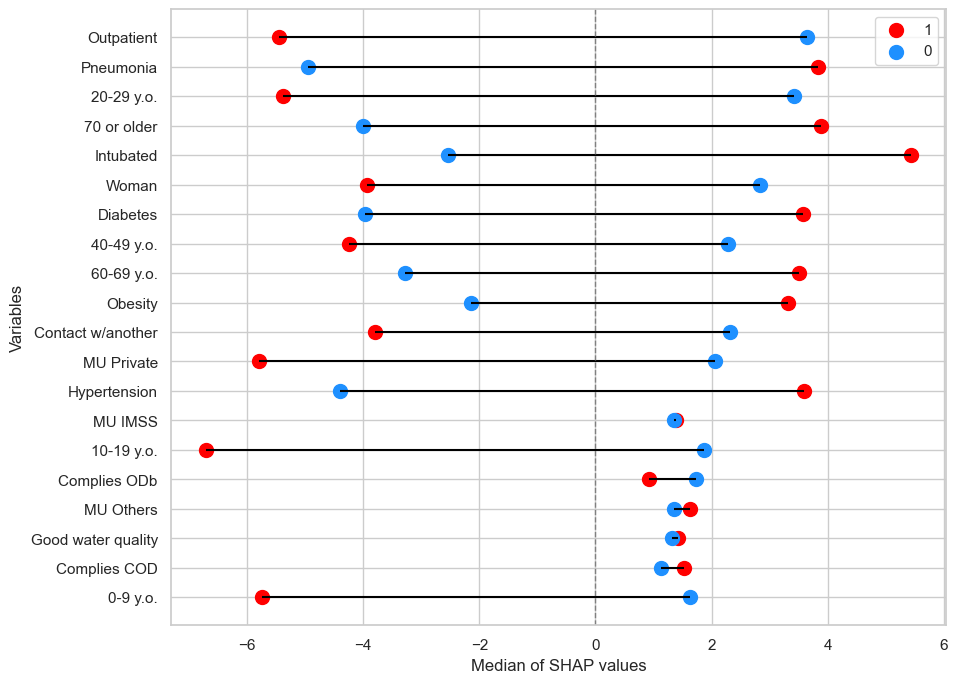

In [45]:
sns.set(style="whitegrid")


df_medianas = df_resumen_tendencia_simple[['mediana_shap_cuando_1', 'mediana_shap_cuando_0']].copy()
df_medianas.reset_index(inplace=True)
df_medianas.columns = ['Variable', 'Mediana_Cuando_1', 'Mediana_Cuando_0']

# Convertir 'Variable' a tipo categórico para mantener el orden
df_medianas['Variable'] = pd.Categorical(df_medianas['Variable'], categories=df_medianas['Variable'], ordered=True)


plt.figure(figsize=(10, 8))


plt.hlines(y=df_medianas['Variable'], 
            xmin=df_medianas['Mediana_Cuando_0'], 
            xmax=df_medianas['Mediana_Cuando_1'], 
            color='black')

plt.scatter(df_medianas['Mediana_Cuando_1'], df_medianas['Variable'], color='red', label='1', s=100)
plt.scatter(df_medianas['Mediana_Cuando_0'], df_medianas['Variable'], color='dodgerblue', label='0', s=100)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
#plt.title('Average SHAP Values (Median) by Variable Across All Models')
plt.xlabel('Median of SHAP values')
plt.ylabel('Variables')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [38]:
menor_importancia_xgb = df_menos_importantes_xgb.drop(columns=['Weight', 'Cover']).sort_values(by='Gain', ascending=False)


In [39]:
# Seleccionar las variables menos importantes según los tres enfoques
variables_menos_importantes_xgb = set(menor_importancia_xgb.head(15)['Variable'])
variables_menos_importantes_shap = set(df_menos_importantes_shap_sorted.head(15)['Variable'])

correlation_df_sorted['Variable'] = correlation_df_sorted['Variable'].str.replace('^shap_', '', regex=True)
variables_menos_importantes_correlation = set(correlation_df_sorted.tail(15)['Variable'])


# Intersección de las variables menos importantes
variables_a_eliminar = variables_menos_importantes_xgb.intersection(variables_menos_importantes_shap).intersection(variables_menos_importantes_correlation)

In [40]:
print(variables_a_eliminar)

{'Medium Health Index', 'WQ_LOTIC_POOR', 'lot_comp_COD', 'Very High Health Index', 'Asthma', 'WQ_LOTIC_GOOD', 'High Health Index', 'Smoking'}


**Boruta**

In [ ]:
boruta_results = []

for idx, splits in enumerate(train_test_splits):
    X_train = splits['X_train']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_test = splits['y_test']

    print(f"\nEvaluando el rendimiento para la División {idx + 1}")

    # Inicializar el modelo con los mejores parámetros
    model = xgb.XGBClassifier(objective='binary:logistic',
                              scale_pos_weight=scale_pos_weight,
                              tree_method='hist', device='cuda',
                              random_state=196, eval_metric='auc')
    model.set_params(**best_params_divisiones_balanceadas[f'Division_{idx + 1}'])

    # Ajustar el modelo
    model.fit(X_train, y_train)

    # Aplicar Boruta
    boruta = BorutaPy(estimator=model,
                      n_estimators='auto',
                      verbose=2,
                      random_state=42)
    boruta.fit(X_train.values, y_train.values)

    # Obtener características relevantes y no relevantes
    relevantes = X_train.columns[boruta.support_].tolist()
    no_relevantes = X_train.columns[boruta.support_ == False].tolist()
    #tentativas = X_train.columns[boruta.support_ == 'tentative'].tolist()
    tentativas = X_train.columns[boruta.support_weak_].tolist()

    ranking = boruta.ranking_

    # Almacenar los resultados
    boruta_results.append({
        'relevantes': relevantes,
        'no_relevantes': no_relevantes,
        'tentativas': tentativas,
        'ranking': ranking
    })

    # Imprimir resultados para esta división
    print("Características relevantes:", relevantes)
    print("Características no relevantes:", no_relevantes)
    print("Características tentativas:", tentativas)
    print("Ranking de características:", ranking)

# Resumir los resultados de Boruta
boruta_summary = {
    'relevantes': defaultdict(int),
    'tentativas': defaultdict(int),
    'no_relevantes': defaultdict(int)
}

for result in boruta_results:
    for feature in result['relevantes']:
        boruta_summary['relevantes'][feature] += 1
    for feature in result['tentativas']:
        boruta_summary['tentativas'][feature] += 1
    for feature in result['no_relevantes']:
        boruta_summary['no_relevantes'][feature] += 1

# Convertir los resultados a DataFrames para visualización
df_boruta_relevantes = pd.DataFrame(boruta_summary['relevantes'].items(), columns=['Variable', 'Frecuencia'])
df_boruta_tentativas = pd.DataFrame(boruta_summary['tentativas'].items(), columns=['Variable', 'Frecuencia'])
df_boruta_no_relevantes = pd.DataFrame(boruta_summary['no_relevantes'].items(), columns=['Variable', 'Frecuencia'])

# Gráfico de las variables relevantes
df_boruta_relevantes.sort_values(by='Frecuencia', ascending=False).plot(kind='bar', figsize=(10, 6), color='olivedrab')
plt.title('Frecuencia de Variables Relevantes según Boruta')
plt.xlabel('Variable')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [96]:
df_boruta_no_relevantes

Variable  Frecuencia
0           ASTHMA          26
1   CARDIOVASCULAR          25
2          SMOKING          25
3              ICU          20
4          HDI_LOW          26
5          HDI_MID          13
6         HDI_HIGH          18
7           HS_LOW          26
8           HS_MID          26
9          HS_HIGH          26
10    HS_VERY_HIGH          26
11          IS_LOW          26
12          IS_MID          26
13         IS_HIGH          15
14        MU_ISSTE          15
15          MU_SSA          11
16     gw_comp_Alk          26
17    gw_comp_Cond          26
18    gw_comp_Hard          25
19     gw_comp_TDS          25
20      gw_comp_Fe          24
21       gw_comp_F          23
22      gw_comp_FC          26
23    gw_comp_NO3N          26
24      gw_comp_As          26
25      gw_comp_Cd          26
26      gw_comp_Cr          26
27      gw_comp_Hg          26
28      gw_comp_Pb          26
29      WQ_GW_POOR          26
30      WQ_GW_GOOD          26
31   WQ_GW_REGULAR           3
32           50_59          12
33           30_39           1
34     MU_MILITARY           2
35    ANOTHER_CASE           3
36    IS_VERY_HIGH           1
37        IMMUSUPP           2

In [111]:
#df_boruta_relevantes

df_boruta_relevantes_filtrado = df_boruta_relevantes[df_boruta_relevantes['Frecuencia'] == 26]

df_boruta_relevantes_filtrado

Variable  Frecuencia
0              WOMAN          26
1   NON_HOSPITALIZED          26
2          INTUBATED          26
3          PNEUMONIA          26
4           DIABETES          26
5               COPD          26
7       HYPERTENSION          26
8            OBESITY          26
9                CKD          26
11               0_9          26
12             10_19          26
13             20_29          26
15             40_49          26
17             60_69          26
18          70_OLDER          26
19     HDI_VERY_HIGH          26
21           MU_IMSS          26
23        MU_PRIVATE          26
24         MU_OTHERS          26
25        gw_comp_Mn          26

In [98]:
df_boruta_tentativas

Variable  Frecuencia
0          IS_HIGH           6
1           MU_SSA           5
2        gw_comp_F           1
3          HDI_MID           6
4         HDI_HIGH           3
5          SMOKING           4
6   CARDIOVASCULAR           7
7         MU_ISSTE           6
8     gw_comp_Hard           2
9              ICU           3
10      WQ_GW_POOR           2
11           30_39           1
12           50_59           5
13     MU_MILITARY           2
14      gw_comp_Fe           2
15   WQ_GW_REGULAR           2
16     gw_comp_TDS           2
17    IS_VERY_HIGH           1
18        IMMUSUPP           1